In [102]:
# Import Packages
import numpy as np
import pandas as pd
#import tableMakerv2 as tm2
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.lines import Line2D
from matplotlib import animation
import time
import re
import warnings
from random import randint
import concurrent
from concurrent.futures import ProcessPoolExecutor
import multiprocessing as mp
import ipywidgets as wgt
#from Archive import tableMaker as tableMaker

# Reimport changes when editing LiuInt or tableMaker
#import importlib
#importlib.reload(tm2)

#### TableMaker (tm2) code
Placing this in-line for faster edits (removes the need to recompile the table every time.)

In [308]:
import numpy as np
from scipy.interpolate import interp1d
from scipy.integrate import quad
from scipy.optimize import fsolve, ridder, least_squares, root
import os
import warnings
from glob import glob
from re import match, search
from statistics import variance
import LiuInt as LI # Package with functions for integrating over the BPDF, parameterized by xi_avg and xi_variance
from scipy.interpolate import RegularGridInterpolator as rgi
from datetime import datetime
import multiprocessing as mp

############################## tableMakerv2

def compute_progress_variable(data, header, c_components = ['H2', 'H2O', 'CO', 'CO2']):
    """
    Progress variable is defined as the sum of the mass fractions of a specified set of c_components.
    This function computes the flame progress variable using:
        data = Data from a flame simulation. Each row corresponds to a specific property.
            In the case of this package, this data array is "transposed_file_data" inside the function "get_file_data"
                ex. data[0] = array of temperature data.
        header = 1D array of column headers, denoting which row in "data" corresponds to which property.
            ex. If header[0] = "Temp", then data[0] should be temperature data.
        c_components = list defining whih components' mass fractions are included in the progress variable. 
            By default, this is set to be ['H2', 'H2O', 'CO', 'CO2']
            The strings in the list should each match a string used in 'header'
    """
    #---------- Determine where the c_components are in 'data'
    indices = np.ones(len(c_components), dtype = np.int8)*-1
    for i in range(len(header)):                # For each element in the header, 
        for y in range(len(c_components)):      # Check for a match among the passed-in c_components
            if header[i]==c_components[y].replace(" ",""):
                indices[y] = int(i)             # Indices must be strictly integers
                
    # Confirm all indices were located
    for j, ind in enumerate(indices):
        if ind == -1:
            raise ValueError(f"No match found for {c_components[j]}.")

    #---------- Compute progress variable
    c = np.zeros(len(data[0]))        # Initialize c array
    for d in range(len(data[0])):     # For each column,
        sum = 0
        for index in indices:         # For each of the components specified, 
            sum += data[index,d]      # Sum the mass fractions of each component
        c[d] = sum
    return c 

##############################

def get_data_files(path_to_data, Lvals, tvals, file_pattern = r'^L.*.dat$', \
                   c_components = ['H2', 'H2O', 'CO', 'CO2']):
    """
    Reads and formats data computed by a square grid of flame simulations.
    Inputs: 
        path_to_data = path to simulation data relative to the current folder. 
            NOTE: The data headers must be the last commented line before the data begins.
            The code found at https://github.com/BYUignite/flame was used in testing. 
        Each file will have been run under an array of conditions L,t:
        Lvals: values of parameter L used, formatted as a list (ex. [ 0.002, 0.02, 0.2])
        tvals: values of parameter t used, formatted as a list (ex. [ 0    , 1   , 2  ])
        file_pattern = regular expression (regex) to identify which files in the target folder are data files.  
            DEFAULT: r'^L.*.dat$'. This grabs any files that begin with "L" and end with ".dat". 
        c_components = list defining whih components' mass fractions are included in the progress variable. 
            By default, this is set to be ['H2', 'H2O', 'CO', 'CO2']
            
    Outputs:
        all_data = an array with the data from each file, indexed using all_data[Lval][tval][column# = Property][row # = data point]
        headers  = an array with the column labels from each file, indexed using headers[Lval][tval]
            Each file should have the same columns labels for a given instance of a simulation, but all headers are redundantly included.
        extras   = an array storing any extra information included as comments at the beginning of each file, indexed using extras[Lval][tval]
            This data is not processed in any way by this code and is included only for optional accessibility
    """
    #---------- Check if the provided path is a valid directory
    if not os.path.isdir(path_to_data):
        print(f"Error: {path_to_data} is not a valid directory: no data loaded.")
        return None
    
    #---------- Use glob to list all files in the directory
    files = sorted(glob(os.path.join(path_to_data, '*')))
    
    #---------- Store data and filenames
    filenames = np.array([])
    data_files = np.array([])
    for file in files:
        if match(file_pattern, os.path.basename(file)):
            filenames = np.append(filenames,  os.path.basename(file))
            data_files= np.append(data_files, file)
    #print(filenames) # DEBUGGING
    #print(Lvals)     # DEBUGGING
    #print(tvals)     # DEBUGGING

    #---------- Initialize data arrays
    all_data = np.empty((len(Lvals),len(tvals)), dtype=np.ndarray)  # Initialize to grab data values
    headers  = np.empty((len(Lvals),len(tvals)), dtype=np.ndarray)  # Initialize to store headers
    extras   = np.empty((len(Lvals),len(tvals)), dtype=np.ndarray)  # Initialize to store extra info before header

    #---------- Grab and store data
    for i in range(len(data_files)):
        # This indexing assumes the same # of time scales were run for each length scale
        l = i//len(tvals)   # Row index
        t = i %len(tvals)   # Column index
        
        file = data_files[i]
        with open(file, 'r') as f:
            #---------- Make sure the assigned L and t value are in the file name:
            #print(f"Desired L,  r = {Lvals[l]}, {tvals[t]} ; Filename = {f.name}") # DEBUGGING
            if str(Lvals[l]) not in f.name:
                print(f"Warning: for file name '{f.name}', mismatch: L = {Lvals[l]}")
            if str(tvals[t]) not in f.name:
                print(f"Warning: for file name '{f.name}', mismatch: t = {tvals[t]}")

            #---------- Get raw data
            lines = f.readlines()
            raw_data = np.array([line.strip() for line in lines if not line.startswith('#')])

            #---------- Grab the header and extra data (included as commented lines)
            IsHeader = True
            header = np.array([])
            extra = np.array([])
            for line in reversed(lines):               #The last of the commented lines should be the headers,
                if line.startswith('#'):               #so we grab the last of the commented lines
                    vals = np.array([val for val in line.strip().split() if val !='#'])
                    if IsHeader == True:
                        for val in vals:
                            #Remove preemtive numbers in the column labels, then store column label (assumes labels formatted as colNum_property, e.g. 0_T)
                            #This label is used later to select which property to use when creating the table
                            header = np.append(header, val.split("_")[1])  
                        IsHeader = False               #The next line won't be the header, but should be stored in 'extras'
                    else:
                        for val in vals:
                            extra = np.append(extra, val)
        header = np.append(header, "c")
        headers[l,t] = header
        extras[l,t]  = extra
        
        #---------- Parse out numerical values
        #NOTE: the following lines could be achieved with np.loadtxt(). Because we've already read in the lines
        #      to extract the headers, we can extract the data manually with a few extra lines of code.
        
        file_data = np.empty(len(raw_data[0].split()))     # Holds the data for this file
        for row in raw_data:
            numbers = np.array([float(val) for val in row.split()])
            file_data = np.vstack((file_data,numbers))     # Adds each new row of data as a new row in file_data
        file_data = file_data[1:file_data.size]            # Get rid of first column (which is empty and only used for initialization)

        #---------- Transpose data so that each row contains data for a certain property (ex. one row is temperature data, one is density, etc.)
        transposed_file_data = file_data.T

        #---------- Add a row with progress variable (c)
        c = compute_progress_variable(transposed_file_data, header, c_components = c_components)
        transposed_file_data = np.vstack((transposed_file_data, c))   #Stacks this array of progress variable values as the last row 
        
        #---------- Arrange data by l and t indices
        all_data[l,t] = transposed_file_data
    
    #all_data is indexed using all_data[Lval][tval][column# = Property][row # = data point]
    return all_data, headers, extras

##############################

#----- Test get_data_files 
# Lvals = [0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
# tvals = np.arange(0,11,1)
# test = get_data_files(path, Lvals, tvals)[0][0][1]
# test[len(test)-1]
# test[0]

##############################

def phi_funcs(path_to_flame_data, Lvals, tvals, file_pattern = r'^L.*.dat$', c_components = ['H2', 'H2O', 'CO', 'CO2'],
             phi = 'T', Lt = False, mix_frac_name = "mixf", interpKind = 'cubic', get_data_files_output = None):
    """
    Returns an array of interpolated functions phi(ξ) where phi is any property of the flame.\n
    Inputs:\n
        path_to_data = path to simulation data relative to the current folder. \n
            NOTE: The data headers must be the last commented line before the data begins.\n
            The code found at https://github.com/BYUignite/flame was used in testing. \n
        Each file will have been run under an array of conditions L,t:\n
        Lvals: values of parameter L used, formatted as a list (ex. [ 0.002, 0.02, 0.2])\n
        tvals: values of parameter t used, formatted as a list (ex. [ 0    , 1   , 2  ])\n
        file_pattern = regular expression (regex) to identify which files in the target folder are data files. \n
            DEFAULT: r'^L.*.dat$'. This grabs any files that begin with "L" and end with ".dat". \n
        c_components = list defining which components' mixture fractions are included in the progress variable.\n 
            By default, this is set to be ['H2', 'H2O', 'CO', 'CO2']\n
        phi = desired property (ex. 'T', 'rho', etc.), case sensitive. Default = 'T'\n
            Available phi are viewable using "get_data_files(params)[1]".\n
            NOTE: c (progress variable) is available in the data. By default, c ≡ y_CO2 + y_CO + y_H2O + yH2. \n
            This definition can be changed by modifying the c_components parameter.\n
        Lt = Tuple with indices corresponding to the desired L and t. If set to False (default), the output will be an array of the functions phi(ξ) for all datafiles. \n
             Otherwise, this parameter determines which specific file should be used. \n
             Example1: phi_funcs(path, phi = 'T', Lt = (0,1)): returns the interpolated T(ξ) function ONLY from the data in the file from Lvals[0], tvals[1]. \n
             Example2: phi_funcs(path, phi = 'T'): returns an array containing the interpolated T(ξ) functions from every file in the directory\n
             Note that the values in this tuple are not values of L and t, but rather indexes of Lvals and tvals.\n
        mix_frac_name = name of the column header for mixture fraction. Default value: "mixf"\n
        interpKind = specifies the method of interpolation that should be used (uses scipy.interp1d). Default = 'cubic'. \n
        get_data_files_output = used to save time in the event that multiple tables are to be constructed. \n
            This should be the output of get_data_files, run with the relevant parameters matching those passed in to this function.\n
        
    Outputs:\n
        The output type of phi_funcs will depend on the input parameter "fileName":\n
             - If Lt is not defined (default), the output will be an array of functions.\n
             - If Lt is specified, the output will be the function for the specified file only. \n
    """
    #---------- Import data, files, and headers
    if get_data_files_output == None:
        # No processed data passed in: must generate.
        data, headers, extras = get_data_files(path_to_flame_data, Lvals, tvals, file_pattern = file_pattern, c_components = c_components)
    else:
        # Use pre-processed data
        data, headers, extras = get_data_files_output
    
    #---------- Get list of available phi (list of all data headers from original files)
    if type(Lt) == bool:
        # User did not specify a specific file.
        # This code here assumes that all datafiles have the same column labels and ordering:
        phis = headers[0][0] 
    elif Lt[0] < len(headers) and Lt[1] < len(headers[0]):
        # User specified a file and the indices were valid.
        phis = headers[Lt[0]][Lt[1]]
    else:
        # User specified a file and the indices were invalid.
        raise ValueError(f"""(L,t) indices '{Lt}' are invalid. Valid ranges for indices:
        L: (0,{len(headers)-1})
        t: (0,{len(headers[0])-1})""")
    
    #---------- Interpret user input for "phi", find relevant columns
    phi_col = -1
    xi_col = -1
    
    for i in range(len(phis)):
        if phis[i]==phi.replace(" ",""):
            # Phi column identified
            phi_col = i
        if phis[i]==mix_frac_name:
            # Mixture fraction column identified
            xi_col = i
    if phi_col == -1:
        # Phi wasn't found.
        raise ValueError("{} not recognized. Available phi are:\n {}".format(phi, phis))
    if xi_col == -1:
        # Xi wasn't found.
        raise ValueError(f"Mixture fraction ('{mix_frac_name}') was not found among data columns.")

    #---------- Interpolate phi(xi)
    phi_funcs = np.empty((len(Lvals),len(tvals)), dtype=np.ndarray)
    if Lt == False:
        #User did not specify file: must interpolate for every file
        for l in range(len(data)):
            for t in range(len(data[l])):
                xis = data[l][t][xi_col]
                phis = data[l][t][phi_col]
                phi_funcs[l][t] = interp1d(xis, phis, kind = interpKind)
        return phi_funcs
    else:
        #User specified a file
        xis = data[Lt[0]][Lt[1]][xi_col]
        phis = data[Lt[0]][Lt[1]][phi_col]
        return interp1d(xis, phis, kind = interpKind)

##############################

#----- Testing phi_funcs
# Lvals = [0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
# tvals = np.arange(0,11,1)
# phi_funcs(path, Lvals, tvals, Lt = (0,1))(0.5)
# phi_funcs("../flame/run", fileName = 'james')

##############################
    
def make_lookup_table(path_to_flame_data, Lvals, tvals, file_pattern = r'^L.*.dat$', c_components = ['H2', 'H2O', 'CO', 'CO2'],
                    phi = 'T', interpKind = 'cubic', numXim:int=5, numXiv:int = 5, get_data_files_output = None,
                    ximLfrac = 0.5, ximGfrac = 0.5):
    # NOTE: arguments later on unpack args for this function using *args. Only add parameters to the end of the
    # current list of parameters. If removing parameters, be sure to revise calls of this function later in the code.
    """
    Creates a 4D lookup table of phi_avg data. Axis are ξm, ξv, L, and t. 
    Inputs:
        path_to_flame_data = path to simulation data relative to the current folder. 
            NOTE: The data headers must be the last commented line before the data begins.
            The code found at https://github.com/BYUignite/flame was used in testing. 
        Each file will have been run under an array of conditions L,t:
        Lvals: values of parameter L used, formatted as a list (ex. [ 0.002, 0.02, 0.2])
        tvals: values of parameter t used, formatted as a list (ex. [ 0    , 1   , 2  ])
        file_pattern = regular expression (regex) to identify which files in the target folder are data files. 
            DEFAULT: r'^L.*.dat$'. This grabs any files that begin with "L" and end with ".dat". 
        c_components = list defining which components' mixture fractions are included in the progress variable. 
            By default, this is set to be ['H2', 'H2O', 'CO', 'CO2']
        phi = property for which values will be tabulated (ex. 'T', 'rho', etc.), case sensitive. Default = 'T'
            Available phi are viewable using "get_data_files(params)[1]".
            NOTE: c (progress variable) is available in the data. By default, c ≡ y_CO2 + y_CO + y_H2O + yH2. 
            This definition can be changed by modifying the c_components parameter.
        interpKind = specifies the method of interpolation that should be used (uses scipy.interp1d). Default = 'cubic'. 
        ximLfrac: fraction of the domain that should contain ximGfrac*100% of the total npoints
        numXim, numXiv: Number of data points between bounds for ξm and ξv, respectively. Default value: 5
        get_data_files_output = used to save time in the event that multiple tables are to be constructed. 
            This should be the output of get_data_files, run with the relevant parameters matching those passed in to this function.
        ximLfrac: (0 to 1), fraction of the xim domain that should contain ximGfrac of the total numXim points
        ximGfrac: (0 to 1), fraction of the total numXim points that should fall inside of ximLfrac of the total domain.
            Example: if ximLfrac = 0.2 and ximGfrac = 0.5, then 50% of the numXim points will fall in the first 20% of the domain.
    """
    # If get_data_files_output is not provided, the function will call get_data_files to generate the data.
    funcs = phi_funcs(path_to_flame_data, Lvals, tvals, file_pattern = file_pattern, c_components = c_components, \
                      phi = phi, interpKind = interpKind, get_data_files_output = get_data_files_output)

    #---------- Create arrays of ξm and ξv
    if ximLfrac == ximGfrac:
        Xims = np.linspace(0,1,numXim)      #Xim = Mean mixture fraction.
    else:
        nsteps = numXim-1
        dx = np.ones(nsteps)/(nsteps)
        n1 = int(nsteps*ximGfrac)
        if n1 != 0:
            dx1 = ximLfrac/n1
            dx[0:n1] = dx1
            n2  = nsteps - n1
            if n2 != 0:
                dx2 = (1-ximLfrac)/n2
                dx[n1:] = dx2
        Xims = np.zeros(numXim)
        for i in range(len(Xims)-1):
            Xims[i+1] = Xims[i] + dx[i]
        Xims[-1] = 1.0
    Xivs = np.linspace(0,1,numXiv)      #Xiv = Mixture fraction variance. Maximum valid Xiv depends on Xim, so we normalize the values to the maximum
    
    #----------- Table Creation
    table = np.full((numXim, numXiv, len(Lvals), len(tvals)), -1.0)
    for m in range(len(Xims)):                                               #Loop over each value of ξm
        xim = Xims[m]
        for v in range(len(Xivs)):                                           #Loop over each value of ξv
            xiv = Xivs[v]*xim*(1-xim)
            for l in range(len(Lvals)):
                for t in range(len(tvals)):
                    phiAvg = LI.IntegrateForPhiBar(xim, xiv, funcs[l][t])    #Calculates phi_Avg
                    table[m,v,l,t] = phiAvg                                  #FINAL INDEXING: table[m,v,l,t]

                            
    #Returns: table itself, then an array of the values of Xims, Xivs, Lvals, and tvals for indexing the table.
    #Ex. table[7][6][5][4] corresponds to Xim = indices[0][7], Xiv = indices[1][6], L = indices[2][5], t = indices[3][4].
    #Note: Xiv is normalized to the maximum. For table[1][2][3][4], the actual value of the variance would be indices[1][6]*Xivmax,
    #      where Xivmax = Xim*(1-Xim) =  indices[0][7]*(1-indices[0][7])
    
    indices = [Xims, Xivs, Lvals, tvals]
    return table, indices

##############################

def create_interpolator_mvlt(data, inds, interpKind = 'linear'):
    """
    Creates an interpolator using RegularGridInterpolator (rgi).
    Inputs:
        data, inds =  table and indices created by make_lookup_table
        interpKind = interpolation method that RegularGridInterpolator should use. Default = 'linear'
    The returned function is called with func(xim, xiv, L, t)
    """
    xi_means = inds[0]
    xi_vars = inds[1] #Normalized to Xivmax
    Ls = inds[2]
    ts = inds[3]

    interpolator = rgi((xi_means, xi_vars, Ls, ts), data, method = interpKind)

    def func(xim, xiv, L, t):
        # Function returned to the user.
        """
        Interpolates for a value of phi given:
            Xi_mean
            Xi_variance (actual value)
            Length scale
            Time scale
        """
        xiv_max = xim*(1-xim)
        if xiv > xiv_max:
            raise ValueError(f"xiv must be less than xivMax. With xim = {xim}, xiv_max = {xiv_max}. Input xiv = {xiv}")
        if xiv_max == 0:
            if xiv != 0:
                print(f"Warning: xim = {xim}, meaning xiv_max = 0. xiv passed in was {xiv}, but has been overridden to xiv = 0.")
            xiv_norm = 0
        else:
            xiv_norm = xiv/xiv_max
        try:
            return interpolator([xim, xiv_norm, L, t])
        except Exception as e:
            print("Invalid argument passed into interpolator")
            print("Values passed into interpolator: ", xim, xiv_norm, L, t, "( xiv=", xiv, ")") #DEBUGGING
            print(f"Exception raised: {e}")
    
    return func
    
##############################

def Lt_from_hc_newton(hgoal, cgoal, xim, xiv, hInterp, cInterp, Lbounds, tbounds, 
                 norm, detailedWarn:bool = False, maxIter:int = 100, saveSolverStates:bool = False, 
                 useStoredSolution:bool = True, LstepParams = [0.25, 0.01, 0.003], 
                 tstepParams = [0.25, 9.5, 0.02]):
    """
    Solves for (L,t) given values of (h,c) using a 2D Newton solver.
    Params:
          hgoal: value of enthalpy
          cgoal: value of progress variable
            xim: mean mixture fraction
            xiv: mixture fraction variance
        hInterp: interpolated function for h(xim, xiv, L, t), created using "create_interpolator_mvlt"
        cInterp: interpolated function for c(xim, xiv, L, t), created using "create_interpolator_mvlt"
        Lbounds: tuple containing the minimum and maximum value of L
        tbounds: tuple contianing the minimum and maximum value of L
        norm   := np.max(h_table)/np.max(c_table). Compensates for the large difference in magnitude between typical h and c values.
        detailedWarn: If set to true, more detailed warnings will be raised when the solver does not converge.    
        maxIter: int, sets a limit for the maximum iterations the solver should make.
        saveSolverStates: bool, if set to True, the solver states will be saved to a file in the folder "solver_data"
        useStoredSolution:bool, if set to False, the solver will not use the last solution as its initial guess. 
            Using the last initial guess (default) is generally good: CFD will solve cell-by-cell, and nearby
            cells are expected to have similar values of phi.
        LstepParams: array of parameters used to relax the solver
            LstepParams[0] = 0.25; normal max step size (% of domain)
            LstepParams[1] = 0.01; threshold value of L, below which the max step size is reduced to
            LstepParams[2] = 0.003; reduced max step size (% of domain)
        tstepParams: array of parameters used to relax the solver
            tstepParams[0] = 0.25; normal max step size (% of domain)
            tstepParams[1] = 9.5; threshold value of t, above which the max step size is reduced to
            tstepParams[2] = 0.02; reduced max step size (% of domain)
        
    Returns a tuple of form (L,t)
    This function is to be used for getting values of phi by phi(xim, xiv, [L,t](h,c))
    """
    # NOTE: The following functions assume constant xim and xiv. 
    # These parameters are included in F and X to allow a generic function to be used.

    def F(mvlt):
        # Computes h and c residuals from a set mvlt
        hresid = hInterp(*mvlt) - hgoal
        cresid = (cInterp(*mvlt) - cgoal)*norm # norm ensures both h and c are of similar magnitude
        return np.array([hresid, cresid])
    
    def get_jac(F, X0, F0=None):
        """Computes the 2x2 Jacobian of F(X) at X
        Params:
            F = F(mvlt) = [h(mvlt) - hSet, c(mvlt)-cSet]
                Example code:
                def F(mvlt):
                    return np.array([hInterp(*mvlt)-hSet, cInterp(*mvlt)-cSet])
            X0 = [xim, xiv L, t]
            F0 = F(X0)
        Returns:
            J = [[dH/dL  dH/dt],
                [dc/dL  dc/dt]]
        """
        # Confirm X is an array
        X0 = np.array(X0)
        #print("get_jac initial point: ", X0) #DEGBUGGING

        # Compute F0 if not passed in 
        if F0 is None:
            F0 = F(X0)

        # Set deltas
        scalar = 1e-8 #square root of machine precision
        deltaL = np.array([0, 0, X0[2]*scalar+scalar, 0]) # Adding prevents delta = 0
        deltat = np.array([0, 0, 0, X0[3]*scalar+scalar]) # Adding prevents delta = 0
        
        # Compute gradients
        if X0[2] + deltaL[2] > Lbounds[1]:
            # Avoid stepping over L boundary when adding deltaL
            J0 = (F0 - F(X0 - deltaL))/deltaL[2]  # = [dH/dL, dc/dL]
        else:
            J0 = (F(X0 + deltaL) - F0)/deltaL[2]  # = [dH/dL, dc/dL]

        if X0[3] + deltat[3] > tbounds[1]:
            # Avoid stepping over t boundary when adding deltat
            J1 = (F0 - F(X0 - deltat))/deltat[3]  # = [dH/dt, dc/dt]
        else:
            J1 = (F(X0 + deltat) - F0)/deltat[3]  # = [dH/dt, dc/dt]

        return np.array([J0, J1]).T[0] # Without this final indexing, the shape is (1, 2, 2) instead of (2, 2)
    
    def cramer_solve(F, X0):
        """
        Solves the system of equations JX=F(X0) for X using Cramer's rule.
        Params:
            F: f(mvlt) = [h(mvlt)-hSet, c(mvlt)-cSet]
            X0: [xim, xiv L, t]
        Returns:
            X = [J^(-1)][F(X0)]
        """
        #print("Cramer Solve") # DEBUGGING
        
        # Confirm X is an array
        X0 = np.array(X0)

        # Solve the system
        F0 = F(X0)
        J = get_jac(F, X0, F0)

        #print("F0 = ", F0) #DEBUGGING
        #print("J  = ", J, np.array(J).shape)  #DEBUGGING
        D = (J[0][0]*J[1][1] - J[0][1]*J[1][0])
        D1 = (F0[0]*J[1][1] - J[0][1]*F0[1])
        D2 = (J[0][0]*F0[1] - F0[0]*J[1][0])
        if np.array(D) == 0:
            # Handle nan values. This will happen if the Jacobian is singular. 
            # Physically, this means that the variables are not changing in time, 
            # for example if xim = xiv = 0 (cold, non-reacting mixture). In this 
            # case, we set Lchange and tchange to 0. The remaining solver code
            # will handle the rest.
            Lchange = 0
            tchange = 0
        else:
            Lchange = D1/D
            tchange = D2/D

        # Ensure values returned are floats
        if isinstance(Lchange, np.ndarray):
            Lchange = Lchange[0]
        if isinstance(tchange, np.ndarray):
            tchange = tchange[0]

        # Relax solver: don't allow changes more than a certain fraction of the total domain
        maxFrac_L = LstepParams[0] if X0[2]>LstepParams[1] else LstepParams[2] # Maximum allowable %change in L relative to the domain
        maxFrac_t = tstepParams[0] if X0[3]<tstepParams[1] else tstepParams[2] # Maximum allowable %change in L relative to the domain
        Lrange = np.abs(max(Lbounds) - min(Lbounds))
        trange = np.abs(max(tbounds) - min(tbounds))
        if Lchange != 0:
            Lsign = Lchange/np.abs(Lchange)
        else:
            Lsign = 1.0
        if tchange != 0:
            tsign = tchange/np.abs(tchange)
        else:
            tsign = 1.0
        
        Lchange = np.min([np.abs(Lchange), Lrange*maxFrac_L])*Lsign
        tchange = np.min([np.abs(tchange), trange*maxFrac_t])*tsign
        
        #print("Cramer computed change: ", Lchange, tchange) #DEBUGGING
        return np.array([0, 0, Lchange, tchange])
    
    # Create initial guess
    # Get the directory of the current Python script
    try:
        current_dir = os.path.dirname(os.path.abspath(__file__))
    except:
        # Get the directory of the current jupyter notebook
        current_dir = os.path.dirname(os.path.abspath(''))

    # Check if "file.txt" exists in the same directory
    file_path = os.path.join(current_dir, "newtonsolve_lastsolution.txt")

    Lmin = Lbounds[0]+1e-6
    Lmax = Lbounds[1]-1e-6
    tmin = tbounds[0]+1e-6
    tmax = tbounds[1]-1e-6
    Lstart = (Lmax-Lmin)*0.25+Lmin
    tstart = (tmax-tmin)*0.9+tmin
    if os.path.isfile(file_path) and useStoredSolution:
        guess = np.loadtxt("newtonsolve_lastsolution.txt")
        guess[0], guess[1] = (xim, xiv)
    else:
        guess   = [xim, xiv, Lstart, tstart]

    # Solve parameters
    tolerance = 1e-8  # Minimum SSE for solver to terminate. This was arbitrarily set to a "low" number.
    states = np.tile(guess, (maxIter, 1))
    errors = np.ones(maxIter)
    
    # Solve
    i=0 # Store index: used later to truncate saved data
    for i in range(1, maxIter):    
        #print("Iteration: ", i) # Feedback
        
        # Compute new point
        change = cramer_solve(F, guess)
        guess -= change

        # Enforce bounds
        #     If the new point is out of bounds, it will first correct the solver to a point very close to the boundary. 
        if guess[2] <= Lbounds[0]:
            guess[2] = Lmin
        elif guess[2] >= Lbounds[1]:
            guess[2] = Lmax
        if guess[3] <= tbounds[0]:
            guess[3] = tmin
        elif guess[3] >= tbounds[1]:
            guess[3] = tmax

        # If solver gets stuck, stick it somewhere random
        if i>1 and np.abs(states[i-1][2] - guess[2]) <= tolerance:
            guess[2] = np.random.rand()*(Lmax-Lmin) + Lmin
        elif i>2 and np.abs(states[i-2][2] - guess[2]) <= tolerance:
            guess[2] = np.random.rand()*(Lmax-Lmin) + Lmin
        if i>2 and np.abs(states[i-1][3] - guess[3]) <= tolerance:
            guess[3] = np.random.rand()*(tmax-tmin) + tmin
        elif i>2 and np.abs(states[i-2][3] - guess[3]) <= tolerance:
            guess[3] = np.random.rand()*(tmax-tmin) + tmin
        
        states[i] = guess # Record point in case no solution is found
        errors[i] = np.sum([err**2 for err in F(guess)]) # SSE
        #print("SSE: ", errors[i])                       # Feedback
        #print("State record: \n", states[i], "\n", states[i-1], "\n", states[i-2]) # Feedback
        #print()                                         # Feedback
        
        # Evaluate convergence
        if errors[i] <= tolerance:
            break # Tolerance met: end loop

        # Throw warning if max iterations is exceeded
        if i==maxIter:
            # If maxIter is reached, return the case with the lowest computed SSE:
            guess = states[errors == np.min(errors)][0]
            if detailedWarn:
                warnings.warn(f"""
                            
                Maximum iterations ({maxIter}) exceeded in Lt_from_hc_newton solver.
                This indicates that the exact queried [xim, xiv, h, c] point was not found in the table.
                Using best-case computed result:
                    xim = {guess[0]}
                    xiv = {guess[1]}
                    L   = {guess[2]}
                    t   = {guess[3]}, for the desired point
                    h   = {hgoal}
                    c   = {cgoal}, where
                    SSE for this point in the (h,c) -> (L,t) inversion = {errors[i]:.5g}
                    Average SSE for all attepts at this inversion      = {np.mean(errors):5g}
                Result may be inaccurate.
                """)
            else:
                warnings.warn("NewtonSolve did not fully converge, using case with lowest identified SSE.")
            break

    if saveSolverStates:
        # Define the folder and file paths
        folder_name = "solver_data"
        folder_path = os.path.join(os.getcwd(), folder_name)
        subfolder_name = datetime.now().strftime("%Y%m%d")
        subfolder_path = os.path.join(folder_path, subfolder_name)
        file_name = f"Xim_{xim}_Xiv_{xiv}_h_{hgoal:.4g}_c_{cgoal:.4g}.txt"
        file_path = os.path.join(subfolder_path, file_name)

        # Check if the folder exists, and create it if it doesn't
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)
        if not os.path.exists(subfolder_path):
            os.makedirs(subfolder_path)

        # Save the data as a text file in the folder
        np.savetxt(file_path, np.hstack((states[0:i], np.array([errors[0:i]]).T)))

    # Store solution to use as initial guess next time
    np.savetxt("newtonsolve_lastsolution.txt", guess)
    return [guess[2], guess[3]]

def create_table_aux(args):
    """Auxiliary function used in phi_mvhc for parallelization. 
    The package used for parallelization ("concurrent") requires that the function being parallelized is defined 
    in the global scope.
    """
    # Generic table-generating function
    return make_lookup_table(*args)

def phi_mvhc(path_to_flame_data, Lvals, tvals, file_pattern = r'^L.*.dat$', c_components = ['H2', 'H2O', 'CO', 'CO2'],
             phi = 'T', interpKind = 'cubic', numXim:int=5, numXiv:int = 5, get_data_files_output = None, 
             parallel:bool = True, detailedWarn:bool = False, ximLfrac = 0.5, ximGfrac = 0.5):
    """
    Creates a table of phi values in terms of Xim, Xiv, h,
    Inputs:
        path_to_flame_data = path to simulation data relative to the current folder. 
            NOTE: The data headers must be the last commented line before the data begins.
            The code found at https://github.com/BYUignite/flame was used in testing.
        Lvals: values of parameter L used, formatted as a list (ex. [ 0.002, 0.02, 0.2])
        tvals: values of parameter t used, formatted as a list (ex. [ 0    , 1   , 2  ])
        file_pattern = regular expression (regex) to identify which files in the target folder are data files. 
            DEFAULT: r'^L.*.dat$'. This grabs any files that begin with "L" and end with ".dat". 
        c_components = list defining which components' mixture fractions are included in the progress variable. 
            By default, this is set to be ['H2', 'H2O', 'CO', 'CO2']
        phi = single property or list of properties for which values will be tabulated (ex. 'T', 'rho', etc.), case sensitive. Default = 'T'
            Available phi are viewable using "get_data_files(params)[1]".
            NOTE: c (progress variable) is available in the data. By default, c ≡ y_CO2 + y_CO + y_H2O + yH2.
            This definition can be changed by modifying the c_components parameter.
        interpKind = specifies the method of interpolation that should be used for functions phi(xi) (uses scipy.interp1d). Default = 'cubic'. 
            Note: this is the kind of interpolation that the phi functions will be created with. Once the tabulated values have been created, the rest of the table
                  will be created with a linear interpolation. This prevents excursions to beyond the system bounds due to sparse data. 
        numXim, numXiv: Number of data points between bounds for ξm and ξv, respectively. Default value: 5
        get_data_files_output = used to save time in the event that multiple tables are to be constructed. 
            This should be the output of get_data_files, run with the relevant parameters matching those passed in to this function.
        parallel:bool = if set to True (default), the code will attempt to create tables in parallel.
        detailedWarn: If set to true, more detailed warnings will be raised when the solver does not converge. 
        ximLfrac: (0 to 1), fraction of the xim domain that should contain ximGfrac of the total numXim points
        ximGfrac: (0 to 1), fraction of the total numXim points that should fall inside of ximLfrac of the total domain.
            Example: if ximLfrac = 0.2 and ximGfrac = 0.5, then 50% of the numXim points will fall in the first 20% of the domain.

    Outputs:
        phi_mvhc_arr: Array of phi functions phi = phi(xim, xiv, h, c)
            NOTE: if only one phi is specified, if will still be returned in a single-element array.
        tableArr: array of [table, indices] for each phi, beginning with h and c.

    """
    # ------------ Pre-processing
    # Confirm h and c aren't in phi
    for p in phi:
        if p=='h' or p=='c':
            print("'h' and 'c' are used as table axis and so cannot be used as phi. Cancelling operation.")
            return None

    # Ensure array-like
    if type(phi) == type('str'):
        phi = [phi,]

    # Retrieve data
    if get_data_files_output == None:
        # No processed data passed in: must generate.
        data_output = get_data_files(path_to_flame_data, Lvals, tvals, file_pattern = file_pattern, c_components = c_components)
    else:
        # Use pre-processed data
        data_output = get_data_files_output

    Lbounds = [min(Lvals), max(Lvals)]
    tbounds = [min(tvals), max(tvals)]

    # ------------ Compute tables, parallel or serial
    if not parallel: # Serial computation
        # Create h & c tables
        h_table, h_indices = make_lookup_table(path_to_flame_data, Lvals, tvals, file_pattern, c_components,\
                                             'h', interpKind, numXim, numXiv, data_output, ximLfrac, ximGfrac)
        c_table, c_indices = make_lookup_table(path_to_flame_data, Lvals, tvals, file_pattern, c_components,\
                                             'c', interpKind, numXim, numXiv, data_output, ximLfrac, ximGfrac)
    
        # Create h & c interpolators
        Ih = create_interpolator_mvlt(h_table, h_indices, interpKind = 'linear') #These should only be set to cubic with a very dense table.
        Ic = create_interpolator_mvlt(c_table, c_indices, interpKind = 'linear')
    
        # Create array containing phi tables
        norm = np.max(np.abs(h_table))/np.max(c_table)
        phi_mvhc_arr = []
        tableArr = [[h_table, h_indices], [c_table, c_indices]]
        for p in phi:
            # Get base table with phi data
            table, indices = make_lookup_table(path_to_flame_data, Lvals, tvals, file_pattern, c_components,\
                                             p, interpKind, numXim, numXiv, data_output, ximLfrac, ximGfrac)
    
            # Create interpolator for phi
            InterpPhi = create_interpolator_mvlt(table, indices, interpKind = 'linear')
            
            # Create function phi(xim, xiv, h, c)
            def phi_table(xim, xiv, h, c, maxIter = 100, saveSolverStates = False, useStoredSolution = True, 
                          LstepParams = [0.25, 0.01, 0.003], tstepParams = [0.25, 9.5, 0.02]):
                # Invert from (h, c) to (L, t), then return interpolated value.
                L, t = Lt_from_hc_newton(h, c, xim, xiv, Ih, Ic, Lbounds, tbounds, norm, detailedWarn, 
                                    maxIter, saveSolverStates, useStoredSolution, LstepParams, tstepParams)
                return InterpPhi(xim, xiv, L, t)
    
            phi_mvhc_arr.append(phi_table)
            tableArr.append([table, indices])
        return phi_mvhc_arr, tableArr
        
    else: # Parallel computation
        # Import needed packages
        from concurrent.futures import ProcessPoolExecutor
        import concurrent

        phi = np.append(np.array(['h', 'c']), np.array(phi)) # Need to create h and c tables too, so add them  at the beginning. 
        table_args = [(path_to_flame_data, Lvals, tvals, file_pattern, c_components, p, interpKind, numXim, 
                       numXiv, data_output, ximLfrac, ximGfrac) for p in phi] # Arguments for each table's creation

        # Parallel table creation (should be reviewed)
        with ProcessPoolExecutor(mp_context=mp.get_context('fork')) as executor:
            futures = {executor.submit(create_table_aux, args): idx for idx, args in enumerate(table_args)}
            results = {}
            for future in concurrent.futures.as_completed(futures):
                idx = futures[future]
                try:
                    results[idx] = future.result()
                except Exception as e:
                    print(f"Table creation for index {idx} (phi = {phi[idx]}) generated an exception: {e}")

        # Create h & c interpolators -- These should only be set to cubic interpolation with a very dense table.
        Ih = create_interpolator_mvlt(results[0][0], results[0][1], interpKind = 'linear')
        Ic = create_interpolator_mvlt(results[1][0], results[1][1], interpKind = 'linear')
        
        phi_mvhc_arr = []
        tableArr = [[results[0][0], results[0][1]], [results[1][0], results[1][1]]] # [[h_table, h_indices], [c_table, c_indices]]
        norm = np.max(np.abs(results[0][0]))/np.max(results[1][0])
        if np.isnan(norm):
            norm = np.average(np.abs(results[0][0]))/np.max(results[1][0])
        if np.isnan(norm):
            norm = 1.0
        for i in range(len(phi)-2):
            tableI, indsI = results[i+2]
            InterpPhi = create_interpolator_mvlt(tableI, indsI, interpKind = 'linear')
            # Create function phi(xim, xiv, h, c)
            def phi_table(xim, xiv, h, c, maxIter:int = 100, saveSolverStates = False, useStoredSolution = True,
                          LstepParams = [0.25, 0.01, 0.003], tstepParams = [0.25, 9.5, 0.02]):
                # Invert from (h, c) to (L, t)
                L, t = Lt_from_hc_newton(h, c, xim, xiv, Ih, Ic, Lbounds, tbounds, norm, detailedWarn, 
                                    maxIter, saveSolverStates, useStoredSolution, LstepParams, tstepParams)
                return InterpPhi(xim, xiv, L, t)

            phi_mvhc_arr.append(phi_table) 
            tableArr.append([tableI, indsI])
        return phi_mvhc_arr, tableArr

# Solver Visualization

## Create reference table, h and c interpolators, and T_func

In [105]:
numXim = 80
ximLfrac = 0.2
ximGfrac = 0.4
numXiv = 20
path = r"./data/lignellDec1"
tvals = np.arange(0,11,1)
Lvals = [0.000, 0.004, 0.005, 0.006, 0.01, 0.04, 0.1, 0.2, 0.4, 0.8]
Lbounds = [min(Lvals), max(Lvals)]
tbounds = [min(tvals), max(tvals)]

if input("Run table generation?") == 'y':
    # Make sure Lvals is strictly increasing
    for i in range(len(Lvals)-1):
        if Lvals[i+1] > Lvals[i]:
            pass
        else:
            print(f"NO: {Lvals[i+1]} < {Lvals[i]}")

    #----- Create table
    start = time.time()

    #----- Get function to get T(xim, xiv, h, c)
    result = phi_mvhc(path, Lvals, tvals, phi = 'T', 
                        numXim = numXim, numXiv = numXiv, parallel = True,
                        ximLfrac = ximLfrac, ximGfrac = ximGfrac)

    end = time.time()
    print("Time elapsed creating T_func:", end - start)

# Time elapsed: 35 min

/Users/cougar/jaredporter/inferno/codes/TableMakerMain/postGit/LiuInt.py:128: IntegrationWarning: The occurrence of roundoff error is detected, which prevents 
  the requested tolerance from being achieved.  The error may be 
  underestimated.
  p2 = quad(ϕP, ϵ, 1-ϵ, args = (a, b), points = [ξm,])[0]   # ϵ   < ξ < 1-ϵ
/Users/cougar/jaredporter/inferno/codes/TableMakerMain/postGit/LiuInt.py:128: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  p2 = quad(ϕP, ϵ, 1-ϵ, args = (a, b), points = [ξm,])[0]   # ϵ   < ξ < 1-ϵ
/Users/cougar/jaredporter/inferno/codes/TableMakerMain/postGit/LiuInt

Time elapsed creating T_func: 6863.565862894058


In [173]:
# Unpack results
T_func, tableInfo = result
h_table = tableInfo[0][0]
h_indices = tableInfo[0][1]
c_table = tableInfo[1][0]
c_indices = tableInfo[1][1]
T_table, T_indices = tableInfo[2][0], tableInfo[2][1]

# Create interpolator
hInterp = create_interpolator_mvlt(h_table, h_indices)
cInterp = create_interpolator_mvlt(c_table, c_indices)

# A Priori ODT Analysis

## Full ODT Comparison

In [166]:
#----- Get ODT data

# Ignore the first column of each, which are the radial positions
ODThvals = np.loadtxt(r'../tjet_Dec1/fmeans_enth.dat')[:,1:]
ODTcvals = np.loadtxt(r'../tjet_Dec1/fmeans_progvar.dat')[:,1:]
ODTximvals = np.loadtxt(r'../tjet_Dec1/fmeans_mixf.dat')[:,1:]
ODTxivvals = np.loadtxt(r'../tjet_Dec1/fvar_mixf.dat')[:,1:]
ODTTvals = np.loadtxt(r'../tjet_Dec1/fmeans_temp.dat')[:,1:]
ODTxs = np.loadtxt(r'../tjet_Dec1/fmeans_temp.dat')[:,0]
ODTts = np.loadtxt('../tjet_Dec1/list_of_times.dat')

numRads = len(ODThvals)
numTimes = len(ODThvals[0])

In [75]:
#----- a Priori testing
minODT_T = np.min(ODTTvals)
print(f"Minimum ODT T: {minODT_T}")
if input("Are you sure you want to re-run aPriori?")=='y':
    Tqueried = np.zeros(ODThvals.shape)
    for radInd in range(numRads):
        fracCompleted = radInd/numRads*100
        if fracCompleted%1 <= 0.1 or fracCompleted%0.5 <= 0.1:
            print(f"Working on row {radInd}/{numRads} ({fracCompleted:.1f}% complete)")
        for timeInd in range(numTimes):
            # For each radius and time point, grab the ODT xim, xiv, h, and c values
            h = ODThvals[radInd][timeInd]
            c = ODTcvals[radInd][timeInd]
            xim = ODTximvals[radInd][timeInd]
            xiv = ODTxivvals[radInd][timeInd]

            # Avoid errors due to very small negative values (e.g. -1e-8)
            if xim < 0:
                xim = np.abs(xim)
            if xiv < 0:
                xiv = np.abs(xiv)
            xivmax = xim*(1-xim)
            if xiv > xivmax:
                if xiv-xivmax < 1e-6:
                    print(f"Corrected xiv at rad {radInd}, time {timeInd} from {xiv} to {xivmax}")
                    xiv = xivmax
            if np.abs(ODTTvals[radInd][timeInd] - minODT_T) < 1.0:
                # Flame is essentially not present. Do not query.
                Tqueried[radInd][timeInd] = ODTTvals[radInd][timeInd]
            else:
                # Query the table
                if radInd == 0 and timeInd == 0:
                    Tqueried[radInd][timeInd] = T_func[0](xim, xiv, h, c, useStoredSolution = False, LstepParams = [0.2, 0.01, 0.005], tstepParams = [0.2, 9.5, 0.025])
                else:
                    Tqueried[radInd][timeInd] = T_func[0](xim, xiv, h, c, useStoredSolution = True, LstepParams = [0.2, 0.01, 0.005], tstepParams = [0.2, 9.5, 0.025])
else:
    print("Overridden, a Priori not conducted.")

# Conditions:
#    20 xim, 5 xiv
#    0.2*xim min step
#    Time elapsed: 160 min
# Conditions:
#    80 xim, 20 xiv
#    0.2 min step
#    Time elapsed: 26 min

Minimum ODT T: 299.86943
Working on row 0/1001 (0.0% complete)


/Users/cougar/jaredporter/inferno/codes/TableMakerMain/postGit/tableMakerv2.py:686: UserWarning: NewtonSolve did not fully converge, using case with lowest identified SSE.
  warnings.warn("NewtonSolve did not fully converge, using case with lowest identified SSE.")
/var/folders/55/0qqzz87s5sndf19sv42s64_c0000gq/T/ipykernel_60571/3958188600.py:35: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  Tqueried[radInd][timeInd] = T_func[0](xim, xiv, h, c, useStoredSolution = True, LstepParams = [0.2, 0.01, 0.005], tstepParams = [0.2, 9.5, 0.025])


Working on row 1/1001 (0.1% complete)
Working on row 6/1001 (0.6% complete)
Working on row 11/1001 (1.1% complete)
Working on row 16/1001 (1.6% complete)
Working on row 21/1001 (2.1% complete)
Working on row 26/1001 (2.6% complete)
Working on row 31/1001 (3.1% complete)
Working on row 36/1001 (3.6% complete)
Working on row 41/1001 (4.1% complete)
Working on row 46/1001 (4.6% complete)
Working on row 51/1001 (5.1% complete)
Working on row 56/1001 (5.6% complete)
Working on row 61/1001 (6.1% complete)
Working on row 66/1001 (6.6% complete)
Working on row 71/1001 (7.1% complete)
Working on row 76/1001 (7.6% complete)
Working on row 81/1001 (8.1% complete)
Working on row 86/1001 (8.6% complete)
Working on row 91/1001 (9.1% complete)
Working on row 96/1001 (9.6% complete)
Working on row 101/1001 (10.1% complete)
Working on row 106/1001 (10.6% complete)
Working on row 111/1001 (11.1% complete)
Working on row 116/1001 (11.6% complete)
Working on row 121/1001 (12.1% complete)
Working on row 12

 Completed 1001/1001 rows.
Selected point:
ODT: 971.683068
Table-queried: 1379.3861707224557


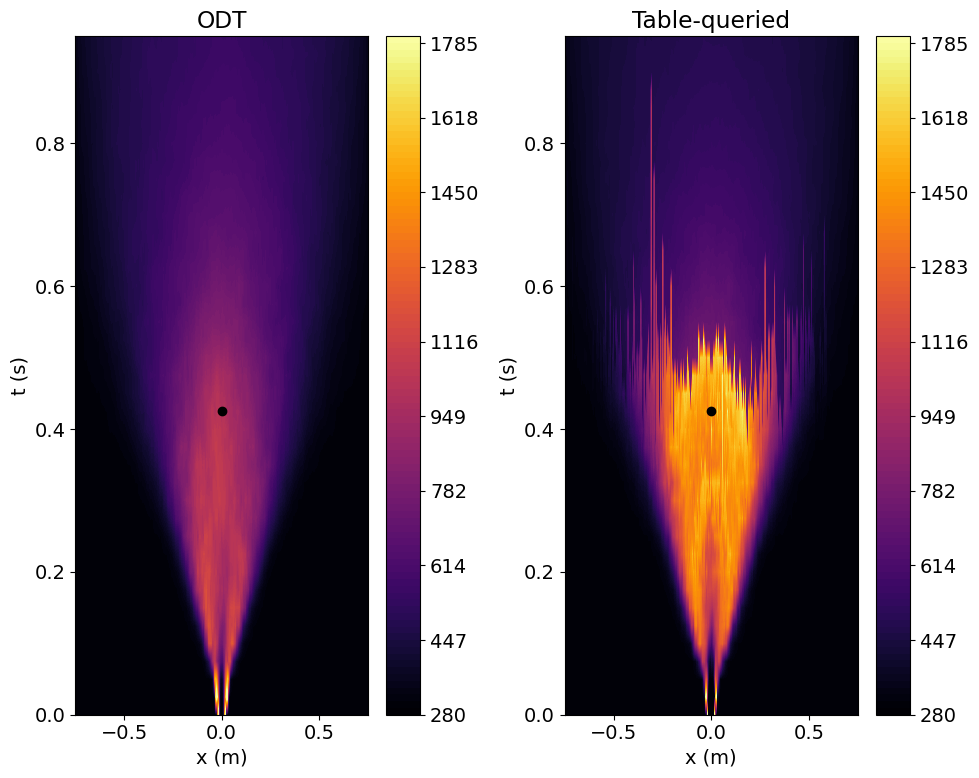

In [92]:
#----- Plot comparison between ODT and a Priori
# In case the analysis was stopped prematurely, display how many rows were queried.
lastCompletedRow = len([Tqueried[i] for i in range(len(Tqueried)) if (Tqueried[i]!=0).all()])
Tqueried_completed = Tqueried[:lastCompletedRow]
print(f" Completed {len(Tqueried_completed)}/{len(ODThvals)} rows.")

# Load data needed for plotting
ODT_Ts = ODTTvals # Get temperature
x = ODTxs         # Get radial positions
levels = np.linspace(280, 1800, 101)
plt.rcParams.update({'font.size': 14})
xx,tt = np.meshgrid(x,ODTts)
fig=plt.figure(figsize=(10,8))
ax = plt.subplot(1, 2, 1)
ax.set_title("ODT")
contour = ax.contourf(xx[0:39],tt[0:39],ODT_Ts.T,100, cmap='inferno', levels = levels)
plt.colorbar(contour, ax = ax)
ax.set_xlabel('x (m)')
ax.set_ylabel('t (s)')
ax.plot(xx[17][500], tt[17][500], 'ko')
ax=plt.subplot(1, 2, 2)
ax.set_title("Table-queried")
contour = ax.contourf(xx[0:-1], tt[0:-1], Tqueried_completed.T, 100, cmap = 'inferno', levels = levels)
ax.set_xlabel('x (m)')
ax.set_ylabel('t (s)')
ax.plot(xx[17][500], tt[17][500], 'ko')
plt.colorbar(contour, ax = ax)
plt.tight_layout();
print("Selected point:")
ximSelected = ODTximvals.T[17][500]
xivSelected = ODTxivvals.T[17][500]
hSelected = ODThvals.T[17][500]
cSelected = ODTcvals.T[17][500]
print(f"ODT: {ODTTvals.T[17][500]}")
print(f"Table-queried: {Tqueried_completed.T[17][500]}")

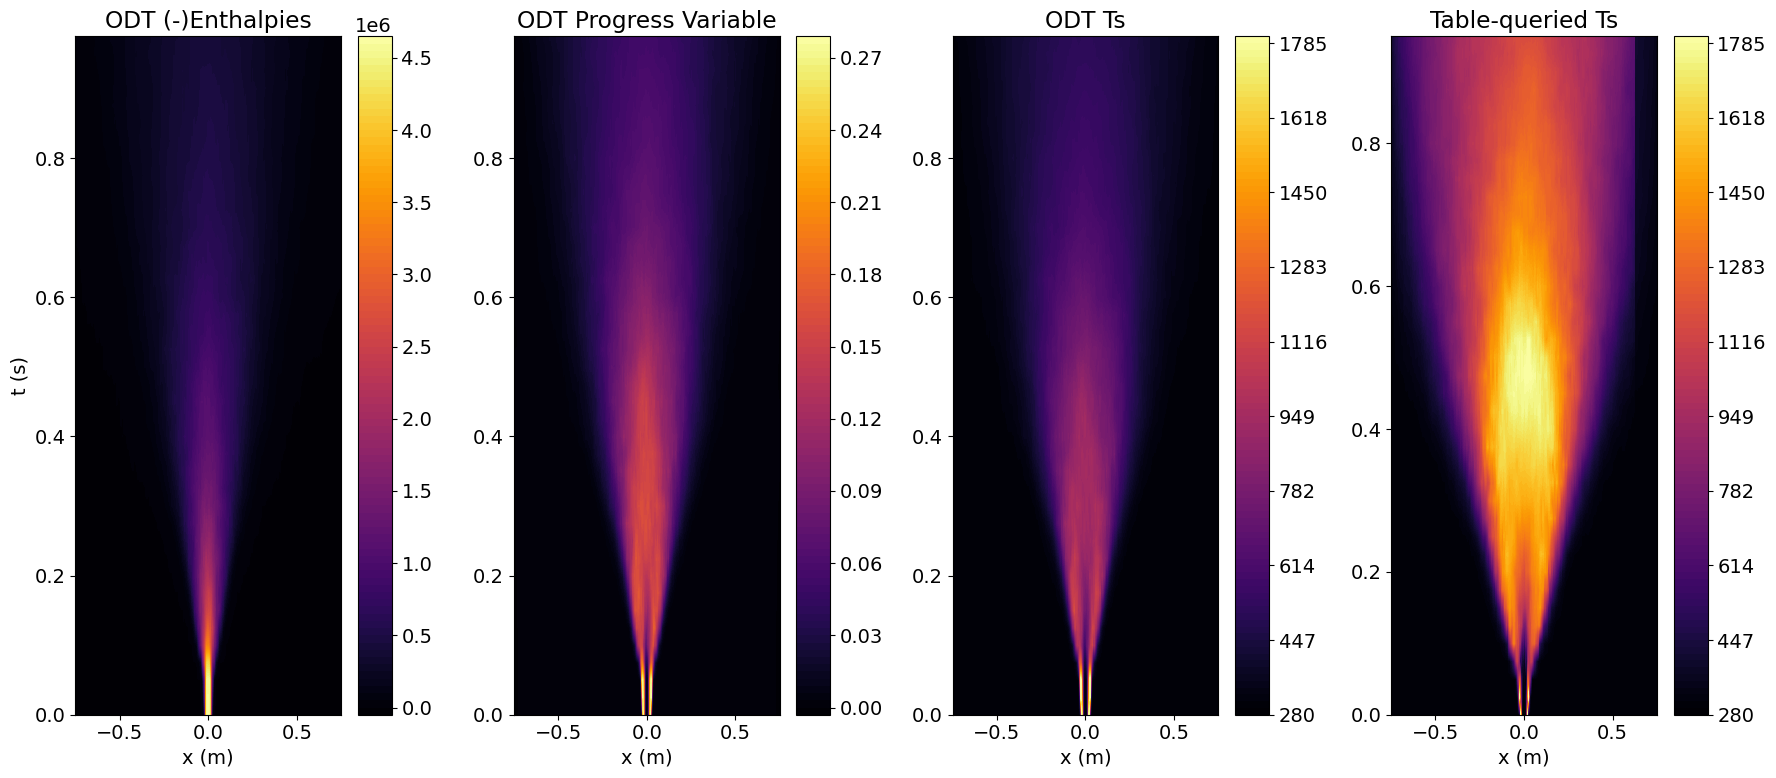

In [58]:
#----- Plot detailed plot with enthalpy and progress variable included
levels = np.linspace(280, 1800, 101)
plt.rcParams.update({'font.size': 14})
fig=plt.figure(figsize=(18,8))
ax = plt.subplot(1, 4, 1)
ax.set_title("ODT (-)Enthalpies")
contour = ax.contourf(xx,tt, -ODThvals.T,100, cmap='inferno')
plt.colorbar(contour, ax = ax)
ax.set_xlabel('x (m)')
ax.set_ylabel('t (s)')
ax = plt.subplot(1, 4, 2)
ax.set_title("ODT Progress Variable")
contour = ax.contourf(xx,tt, ODTcvals.T,100, cmap='inferno')
plt.colorbar(contour, ax = ax)
ax.set_xlabel('x (m)')
ax = plt.subplot(1, 4, 3)
ax.set_title("ODT Ts")
contour = ax.contourf(xx,tt,ODT_Ts.T,100, cmap='inferno', levels = levels)
plt.colorbar(contour, ax = ax)
ax.set_xlabel('x (m)')
ax=plt.subplot(1, 4, 4)
ax.set_title("Table-queried Ts")
contour = ax.contourf(xx[0:-1], tt[0:-1], Tqueried_completed.T, 100, cmap = 'inferno', levels = levels)
ax.set_xlabel('x (m)')
plt.colorbar(contour, ax = ax)
plt.tight_layout();

In [ ]:
#----- Locate max h, c, and T in the table.
ximvals = np.linspace(0,1,10)
xivvals = np.linspace(0,1,10)

if input("Rerun search?") == 'y':
    maxC = 0
    maxCcoords = [0,0,0,0]
    maxH = 0
    maxHcoords = [0,0,0,0]
    maxT = 0
    maxTcoords = [0,0,0,0]
    for ximval in ximvals:
        for xivval in xivvals:
            xivval = ximval*(1-ximval)*xivval
            for lval in Lvals:
                for tval in tvals:
                    cNew = cInterp(ximval, xivval, lval, tval)
                    hNew = hInterp(ximval, xivval, lval, tval)
                    Tnew = T_func[0](ximval, xivval, hNew, cNew)
                    if cNew>maxC:
                        maxC = cNew
                        maxCcoords = [ximval, xivval, lval, tval]
                    if hNew<maxH:
                        maxH = hNew
                        maxHcoords = [ximval, xivval, lval, tval]
                    if Tnew>maxT:
                        maxT = Tnew
                        maxTcoords = [ximval, xivval, lval, tval]

maxCcoords = [float(thing) for thing in maxCcoords]
maxHcoords = [float(thing) for thing in maxHcoords]
maxTcoords = [float(thing) for thing in maxTcoords]

In [209]:
print(f"Max c = {maxC[0]:.4g},     which occurs at {maxCcoords}")
print(f"Max h = {maxH[0]:.4g}, which occurs at {maxHcoords}")
print(f"Max T = {maxT[0]:.4g},       which occurs at {maxTcoords}")
print()
print("Coords are xim, xiv, L, t")

Max c = 0.2906,     which occurs at [0.1111111111111111, 0.0, 0.8, 0.0]
Max h = -2.514e+06, which occurs at [0.1111111111111111, 0.0, 0.8, 10.0]
Max T = 1746,       which occurs at [0.1111111111111111, 0.0, 0.01, 0.0]

Coords are xim, xiv, L, t


## Single ODT Realization

In [306]:
myPath = r'./aPriori/tjet_many2data/data'
filename = '/data_00001/dmp_00036.dat'

if input("Re-query the table?") == 'y':
    # Load in data
    SORdata = np.loadtxt(myPath + filename)

    # Grab header
    with open(myPath + filename, 'r') as f:
        last_line = None
        for line in f:
            if line[0] == '#':
                last_line = line
    SORheader = last_line.split()[1:]
    SORdf = pd.DataFrame(SORdata, columns = SORheader)
    SORdf['30_progVar'] = SORdf['23_y_CO'] + SORdf['24_y_CO2'] + SORdf['12_y_H2'] + SORdf['17_y_H2O']

    # Replace any negative values in the 9th column with 0
    SORdf['9_mixf'] = SORdf['9_mixf'].apply(lambda x: 0 if x < 0 else x)
    
    # Query table
    SORdf['31_Tqueried'] = np.zeros(len(SORdf['2_posf']))
    for i in range(len(SORdf['2_posf'])):
        xim = SORdf['9_mixf'][i]
        h = SORdf['29_enth'][i]
        c = SORdf['30_progVar'][i]
        # Temporarily suppress warnings
        with warnings.catch_warnings():
            SORdf.loc[i, '31_T_queried'] = T_func[0](xim, 0, h, c, useStoredSolution = False, 
                                                     LstepParams = [0.2, 0.01, 0.004], tstepParams = [0.2, 10.1, 0.02], maxIter = 1000)
        if i%30 == 0:
            print(f"Finished row {i}/{len(SORdf['2_posf'])}")

Finished row 0/1607
Finished row 30/1607
Finished row 60/1607
Finished row 90/1607
Finished row 120/1607
Finished row 150/1607
Finished row 180/1607
Finished row 210/1607
Finished row 240/1607
Finished row 270/1607
Finished row 300/1607
Finished row 330/1607
Finished row 360/1607
Finished row 390/1607
Finished row 420/1607
Finished row 450/1607
Finished row 480/1607
Finished row 510/1607
Finished row 540/1607
Finished row 570/1607
Finished row 600/1607
Finished row 630/1607
Finished row 660/1607
Finished row 690/1607
Finished row 720/1607
Finished row 750/1607
Finished row 780/1607
Finished row 810/1607
Finished row 840/1607
Finished row 870/1607
Finished row 900/1607
Finished row 930/1607
Finished row 960/1607
Finished row 990/1607
Finished row 1020/1607
Finished row 1050/1607
Finished row 1080/1607
Finished row 1110/1607
Finished row 1140/1607
Finished row 1170/1607
Finished row 1200/1607
Finished row 1230/1607
Finished row 1260/1607
Finished row 1290/1607
Finished row 1320/1607
Fini

['1_pos', '2_posf', '3_rho', '4_dvisc', '5_uvel', '6_vvel', '7_wvel', '8_temp', '9_mixf', '10_chi', '11_hr', '12_y_H2', '13_y_H', '14_y_O', '15_y_O2', '16_y_OH', '17_y_H2O', '18_y_HO2', '19_y_CH2', '20_y_CH2(S)', '21_y_CH3', '22_y_CH4', '23_y_CO', '24_y_CO2', '25_y_HCO', '26_y_CH2O', '27_y_CH2OH', '28_y_N2', '29_enth']


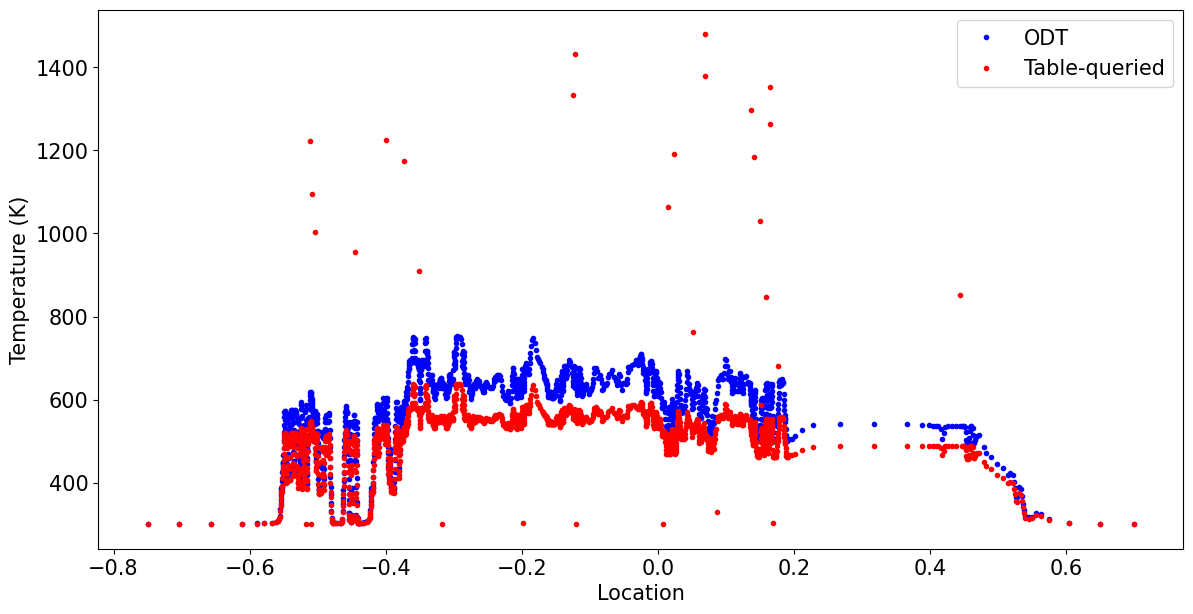

In [307]:
# Visualize results
print(SORheader)
plt.figure(figsize = (14,7))
plt.plot(SORdf['2_posf'], SORdf['8_temp'], 'b.', label = 'ODT')
plt.plot(SORdf['2_posf'], SORdf['31_T_queried'], 'r.', label = 'Table-queried')
plt.xlabel('Location')
plt.ylabel('Temperature (K)')
plt.legend();

## Compare T_func to table values


In [305]:
numCompares = 20
ximLen = len(h_indices[0])
xivLen = len(h_indices[1])
LLen   = len(h_indices[2])
tLen   = len(h_indices[3])

cases = {}
Tcomputed = 0
for i in range(numCompares):
    ximInd = randint(0, ximLen-1)
    xivInd = randint(0, xivLen-1)
    LInd = randint(0, LLen-1)
    tInd = randint(0, tLen-1)
    ximreal = h_indices[0][ximInd]
    xivreal = h_indices[1][xivInd]*ximreal*(1-ximreal)
    Lreal = h_indices[2][LInd]
    treal = h_indices[3][tInd]
    hreal = h_table[ximInd][xivInd][LInd][tInd]
    creal = c_table[ximInd][xivInd][LInd][tInd]
    Treal = T_table[ximInd][xivInd][LInd][tInd]
    warningThrown = False
    with warnings.catch_warnings(record=True) as w:
        warnings.simplefilter("always")
        T_computed = T_func[0](ximreal, xivreal, hreal, creal, saveSolverStates = False, useStoredSolution = False, 
                               LstepParams = [0.2, 0.01, 0.004], tstepParams = [0.2, 10.1, 0.02], maxIter = 1000)
        if w:
            #print(w)
            warningThrown = True

#maxFrac_L = LstepParams[0] if X0[2]>LstepParams[1] else LstepParams[2] # Maximum allowable %change in L relative to the domain
#maxFrac_t = tstepParams[0] if X0[3]<tstepParams[1] else tstepParams[1] # Maximum allowable %change in L relative to the domain
#Lvals = [0.000, 0.004, 0.005, 0.006, 0.01, 0.04, 0.1, 0.2, 0.4, 0.8]
    cases[i] = [ximreal, xivreal, hreal, creal, Lreal, treal, Treal, T_computed[0], ""]
    if np.abs(T_computed-Treal) > 1:
        cases[i][-1] = "T Mismatch"
    if warningThrown:
        cases[i][-1] = "Solver didn't converge"

df = pd.DataFrame(cases, index = ["xim", "xiv", "h", "c", "L", "t", "T", "Tcomputed", "warning"]).T
pd.set_option('display.float_format', '{:.5g}'.format)
df = df.sort_values(by='xim')
df

,xim,xiv,h,c,L,t,T,Tcomputed,warning
15,0,0,1907.6,0,0.006,6,300,300,
14,0.03871,0.031336,-1.8388e+05,0.0070826,0.005,6,336.06,336.06,
7,0.096774,0.032203,-5.5245e+05,0.094514,0.01,9,799.28,799.28,
18,0.11613,0.04862,-6.0005e+05,0.080367,0.006,4,721.99,721.99,
17,0.12258,0.090572,-5.8399e+05,0.020028,0.005,1,401.5,401.5,
3,0.14194,0.07051,-7.2249e+05,0.07144,0.01,3,669.46,669.46,
10,0.14839,0.026604,-1.7569e+06,0.18964,0.8,8,581.5,581.5,
13,0.16129,0.028479,-1.4446e+06,0.19169,0.2,4,897.95,897.95,
5,0.16129,0,-1.6938e+06,0.26073,0.1,3,1044.3,1044.3,
1,0.16774,0.044086,-9.056e+05,0.1558,0.1,0,1076.4,826,T Mismatch


# Functions for creating and plotting contours

In [96]:
def createPlotData(xim, xiv, Ih, Ic, Lbounds, tbounds, num_points = 100):
    """Creates h and c data for a given:
        xim = mean mixture fraction
        xiv = mixture fraction variance. 
            NOTE: The maximum allowable variance is determined by the mean:
                xiv_max = xim*(1-xim)
        Ih = interpolator for h(xim, xiv, L, t)
        Ic = interpolator for c(xim, xiv, L, t)
            NOTE: both of these interpolators can readily be created with tm2.createInterpolator
        Lbounds = 2-element array-like containing bounds for L
        tbounds = 2-element array-like containing bounds for t
        num_points = Resolution of the grid on each axis.
    Returns:
        [Ls, ts, hs, cs], where
            xs = 2D meshgrid array of L, t values (x when plotting in 3D)
            ys = 2D meshgrid array of t, L values (y when plotting in 3D)
            hs = 2D array of h(L, t)
            cs = 2D array of c(L, t)
    """
    num_points = 100
    Ls = np.linspace(min(Lbounds)+1e-4, max(Lbounds)-1e-4, num_points)
    ts = np.linspace(min(tbounds)+1e-4, max(tbounds)-1e-4, num_points)

    xs, ys = np.meshgrid(Ls, ts)
    hs = np.zeros_like(xs)
    cs = np.zeros_like(xs)

    for i in range(num_points):
        for j in range(num_points):
            hs[i, j] = Ih(xim, xiv, xs[i, j], ys[i, j])[0]
            cs[i, j] = Ic(xim, xiv, xs[i, j], ys[i, j])[0]

    return [xs, ys, hs, cs, xim, xiv]

def plotHCLT(hknown, cknown, xs, ys, hs, cs, xim, xiv, Lbounds, tbounds, scatterData = None,
             save:bool = True, figsize = (20,20), nameAddition = None, 
             fontscalar = 1.5, fig = None, LtickSpacing = 0.05):
    """Creates a 3D plot of h(L, t) and c(L, t), as well as a 2D plot showing the
    contour plots of hknown and cknown. The objective is to show visually the space
    within which a given instance of the NewtonSolver in tableMakerv2 is working.
    Inputs:
        hknown = desired value of enthalpy
        cknown = desired value of progress variable
        Ls = 1st array returned from createPlotData
        ts = 2nd array returned from createPlotData
        hs = 3rd array returned from createPlotData
        cs = 4th array returned from createPlotData
        xim = 5th output returned from createPlotData (mean mixture fraction)
        xiv = 5th output returned from createPlotData (mixture fraction variance)
        Lbounds = 2-element array-like containing bounds for L
        tbounds = 2-element array-like containing bounds for t
        scatterData = array of points to show on the (L,t) plot
        save:bool = If set to False, the plot will not be saved as a png, only displayed.
        figsize = (width, height) of the plot in inches. May be set to 'None'
        nameAddition = string to be appended to file name.
        fontscalar = multiplier to control font size. The default value is 1.5, meaning the 
            plot will have a fontsize 1.5x that of the matplotlib default.
        fig = matplotlib figure object. Used for animation.
        LtickSpacing = Spacing between L ticks on the plot. Default is 0.05
    Outputs:
        None
    """
    #----- General Formatting
    if fig is None:
        fig = plt.figure(figsize = figsize)
    if fig is not None:
        fig.clf()
    ccol = 'r'  # Color of the progress variable contour
    hcol = 'b'  # Color of the enthalpy contour
    alpha = 0.7 # Surface transparency
    fontsize = int(10*fontscalar)
    plt.rcParams.update({'font.size': fontsize})  # Global font size update
    pad = fontsize/15.*10

    #----- Plot Progress Variable
    ax = fig.add_subplot(131, projection='3d')
    ax.plot_surface(xs,ys,cs, cmap='viridis', alpha = alpha)

    #Add contours
    ax.contour(xs, ys, cs, zdir='z', levels=[cknown], colors=ccol, linestyles = 'dashed')
    ax.contour(xs, ys, cs, zdir='z', levels=[cknown], colors=ccol, offset = ax.get_zlim()[0],\
               alpha = alpha, linestyles = 'solid')

    #Formatting
    ax.set_title("Progress Variable (L,t)")
    ax.text2D(0.5, 0.95, f'Contour: c* = {cknown:.4g}', transform=ax.transAxes, ha='center')
    ax.set_xlabel("L", labelpad = pad)
    ax.set_xticks(np.arange(min(Lbounds), max(Lbounds)+0.01, LtickSpacing))
    ax.set_xlim(Lbounds)
    ax.set_ylabel("t", labelpad = pad)
    ax.set_zlabel("c", labelpad = 2*pad)
    ax.tick_params(axis='z', pad = 10)
    ax.view_init(30, 110)
    ax.text(ax.get_xlim()[0]*2.5, ax.get_ylim()[0], ax.get_zlim()[1]*1.3,
            f"xim = {xim:.3g}\nxiv = {xiv:.3g}", bbox = dict(facecolor = 'white', edgecolor = 'black', boxstyle='round'))
    
    #----- Plot Enthalpy
    ax = fig.add_subplot(132, projection='3d')
    ax.plot_surface(xs, ys, hs, cmap='inferno', alpha = alpha)

    #Add contours
    ax.contour(xs, ys, hs, zdir='z', levels=[hknown], colors=hcol, linestyles = 'dashed')
    ax.contour(xs, ys, hs, zdir='z', levels=[hknown], colors=hcol, offset = ax.get_zlim()[0],\
               alpha = alpha, linestyles = 'solid')

    #Formatting
    ax.set_title("Enthalpy (L,t)")
    ax.text2D(0.5, 0.95, f'Contour: h* = {hknown:.4g}', transform=ax.transAxes, ha='center')
    ax.set_xlabel("L", labelpad=10)
    ax.set_xticks(np.arange(min(Lbounds), max(Lbounds)+0.01, LtickSpacing))
    ax.set_xlim(Lbounds)
    ax.set_ylabel("t", labelpad = pad)
    ax.set_zlabel(r"h", labelpad = 2*pad, rotation = 0)
    ax.tick_params(axis='z', pad = 10)
    ax.ticklabel_format(axis = 'z', style = 'sci', useMathText = True, scilimits = (-1, 1))
    ax.zaxis.get_offset_text().set_visible(False)
    exponent = int(f'{np.min(hs):.2e}'.split('e')[1])
    zlim = ax.get_zlim()
    xlim = ax.get_xlim()
    ylim = ax.get_ylim()
    ax.text(xlim[0]*1.5, ylim[0], zlim[1] + (zlim[1]-zlim[0])/6,
            '$\\times\\mathdefault{10^{%d}}\\mathdefault{}$' % exponent)
    ax.view_init(30, 110)

    #----- Plot Projections Only
    ax = fig.add_subplot(133)

    #Get projection data
    ax.contour(xs, ys, cs, levels = [cknown], colors = ccol, linestyles = 'solid')
    ax.contour(xs, ys, hs, levels = [hknown], colors = hcol, linestyles = 'solid')
    if scatterData is not None:
        try:
            xDat = np.array(scatterData)[:,0]
            yDat = np.array(scatterData)[:,1]
            scat, = ax.plot(xDat, yDat, '*', color = 'black', label = "Solver")
        except Exception as e:
            print(e)
            raise ValueError("Could not plot scatter data. Ensure data array is formatted correctly")
    ax.set_title("h & c contours")
    ax.set_xlabel("L", labelpad = pad)
    ax.set_xticks(np.arange(min(Lbounds), max(Lbounds)+0.01, LtickSpacing))
    ax.set_xlim(Lbounds)
    ax.set_ylabel("t", rotation = 0, labelpad = pad)
    ax.yaxis.set_label_position('right')
    ax.yaxis.tick_right()
    ax.set_box_aspect(1)
    ax.invert_xaxis()
    ax.invert_yaxis()
    legend_elements = [
        Line2D([0], [0], color=ccol, label="Progress Variable (c)"),
        Line2D([0], [0], color=hcol, label="Enthalpy (h)"),
    ]
    if scatterData is not None:
        legend_elements.append(scat)

    #----- Add legend with the proxy artists
    ax.legend(handles=legend_elements)

    #----- Save and show final result
    plt.tight_layout(pad = 5)
    if save:
        if nameAddition is not None:
            addition = f"_{nameAddition}"
        else:
            addition = ""
        plt.savefig(f'HCLT_c_{cknown:.4g}_h_{hknown:.4g}{addition}.png',bbox_inches='tight')  # Save as a PNG file

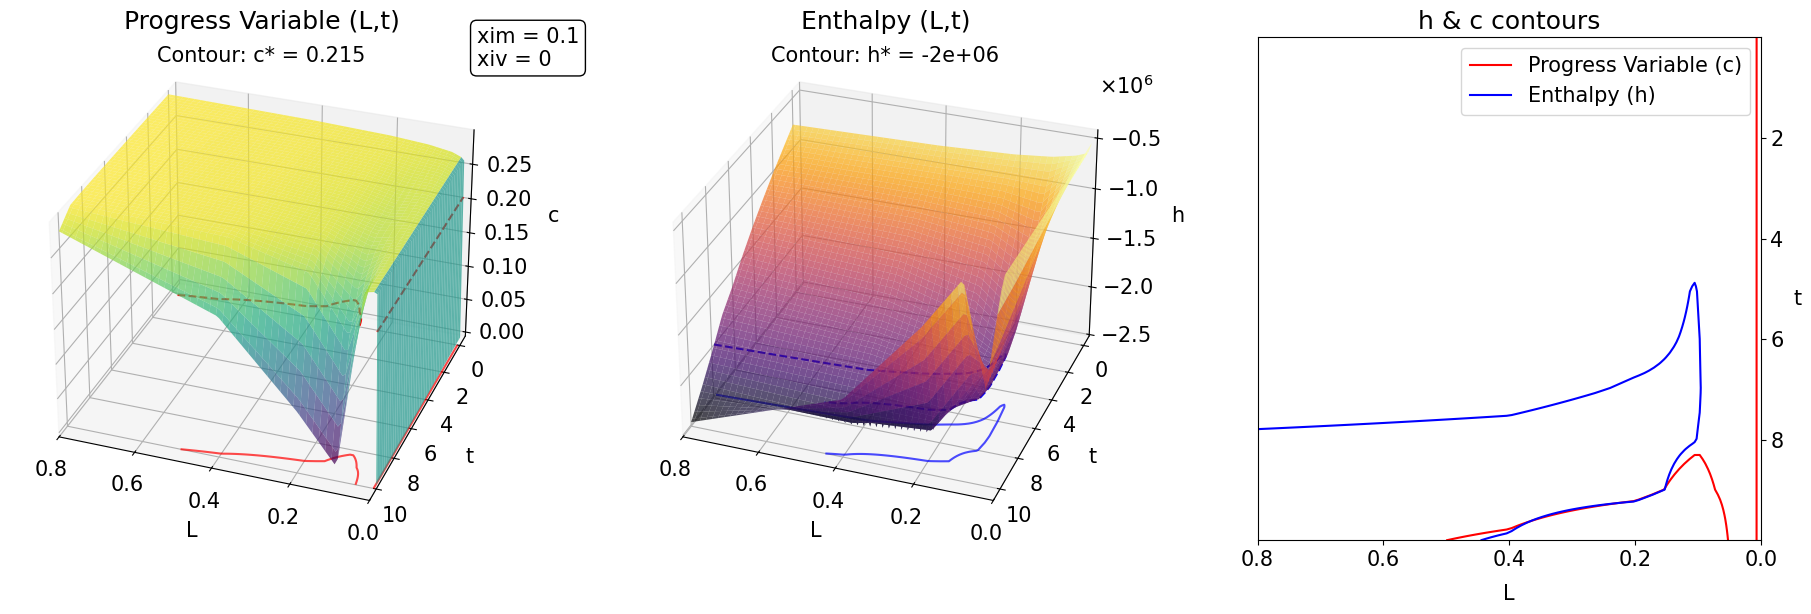

In [108]:
tvals = np.arange(0,11,1)
Lvals = [0.000, 0.004, 0.005, 0.006, 0.01, 0.04, 0.1, 0.2, 0.4, 0.8]
Lbounds = [min(Lvals), max(Lvals)]
tbounds = [min(tvals), max(tvals)]
hInterp = create_interpolator_mvlt(h_table, h_indices)
cInterp = create_interpolator_mvlt(c_table, c_indices)

Ls, ts, hs, cs, xim, xiv = createPlotData(0.1, 0, hInterp, cInterp, Lbounds, tbounds)
plotHCLT(-2e6, 0.215, Ls, ts, hs, cs, 0.1, 0, Lbounds, tbounds, save =  False, LtickSpacing = 0.2)

## Plotting the Contours

Indices:
Radial: 512
Time  : 0

Result:
xim = 0.0837
xiv = 0.00124
h   = -9.98e+05
c   = 0.155
T_table = 913.1 K
T_ODT   = 971.7 K


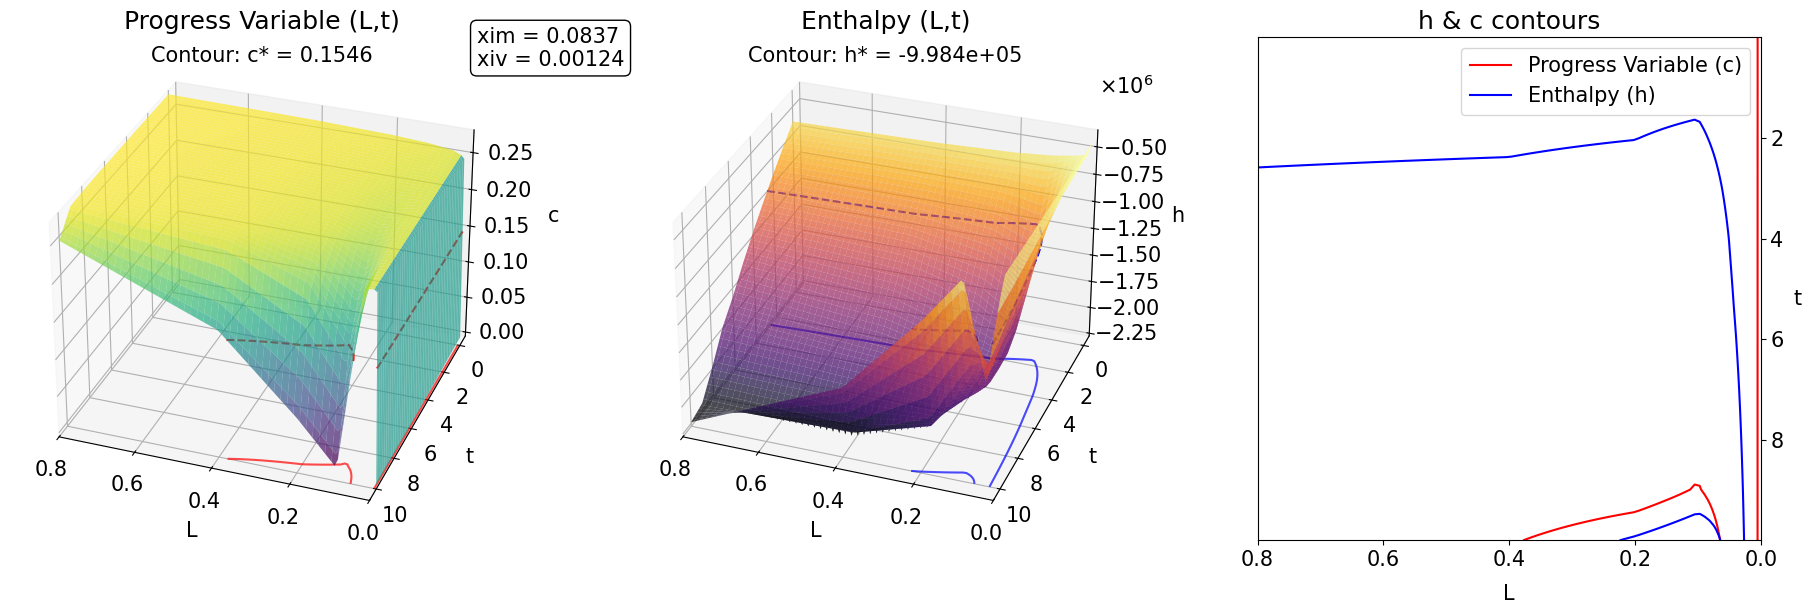

In [153]:
#----- Plot a point from the ODT data
ODThvals = np.loadtxt(r'../tjet/fmeans_enth.dat')[:,1:-1]
ODTcvals = np.loadtxt(r'../tjet/fmeans_progvar.dat')[:,1:-1]
ODTximvals = np.loadtxt(r'../tjet/fmeans_mixf.dat')[:,1:-1]
ODTxivvals = np.loadtxt(r'../tjet/fvar_mixf.dat')[:,1:-1]
ODTTvals = np.loadtxt(r'../tjet/fmeans_temp.dat')[:,1:-1]

numRads = len(ODThvals)
numTimes = len(ODThvals[0])

radLoc = 51.2 # percent through whole domain
tLoc   = 0 # percent through whole domain
radInd = int(numRads*radLoc/100)
tInd   = int(numTimes*tLoc/100)

# xim = np.abs(ODTximvals[radInd][tInd])
# xiv = np.abs(ODTxivvals[radInd][tInd])
# h   = ODThvals[radInd][tInd]
# c   = ODTcvals[radInd][tInd]
# T_ODT = ODTTvals[radInd][tInd]
#T_tablequeried = T_func[0](xim, xiv, h, c, useStoredSolution = False)[0]
xim = ximSelected
xiv = xivSelected
h   = hSelected
c   = cSelected
T_ODT = ODTTvals.T[17][500]
T_tablequeried = T_func[0](xim, xiv, h, c, useStoredSolution = False, saveSolverStates = True, 
                           LstepParams = [0.2, 0.01, 0.0075], tstepParams = [0.2, 9.5, 0.05])[0]
print("Indices:")
print(f"Radial: {radInd}")
print(f"Time  : {tInd}")
print()
print("Result:")
print(f"xim = {xim:.3g}")
print(f"xiv = {xiv:.3g}")
print(f"h   = {h:.3g}")
print(f"c   = {c:.3g}")
print(f"T_table = {T_tablequeried:.4g} K")
print(f"T_ODT   = {T_ODT:.4g} K")

#----- Create plot
hknown = hSelected
cknown = cSelected
Ls, ts, hs, cs, xim, xiv = createPlotData(xim, xiv, hInterp, cInterp, Lbounds, tbounds)
plotHCLT(hknown, cknown, Ls, ts, hs, cs, xim, xiv, Lbounds, tbounds, save =  False, LtickSpacing = 0.2)

## Animations

### Animate over xim and xiv

In [ ]:
#----- Animate over xim and xiv
if input("Create animation over xim and xiv?")=='y':
    # Create data
    xim = 0.25
    xiv = 0.25*xim*(1-xim)

    # Create data and plot
    Ls, ts, hs, cs, xim, xiv = createPlotData(xim, xiv, hInterp, cInterp)
    hknown = -4.0e6
    cknown = 0.24
    xims = np.linspace(0, 1, 10)
    xivFracs = np.linspace(0, 1, 10)

    fig = plt.figure(figsize = (20,20))
    # Function to animate the plot
    def animate(frame):
        ximInd = frame//len(xims)
        xivInd = frame%len(xims)
        print(f"Progress: {(ximInd/len(xims)+xivInd/len(xivFracs)/10)*100:.2f}%")
        xim = xims[ximInd]
        xiv = xim*(1-xim)*xivFracs[xivInd]
        Ls, ts, hs, cs, xim, xiv = createPlotData(xim, xiv, hInterp, cInterp)
        plotHCLT(hknown, cknown, Ls, ts, hs, cs, xim, xiv, save = False, fig = fig)

    # Create the animation
    plt.ioff()
    ani = animation.FuncAnimation(fig, animate, frames=len(xims)**2, interval = 50)

    # Save the animation as a GIF
    ani.save(f"xim_xiv_Animation.gif", writer='pillow', fps=5)
    plt.ion()

### Incorrect Solve

Check vals:  0.0837402716 0.0012405055198286942 -998400.0 0.1546


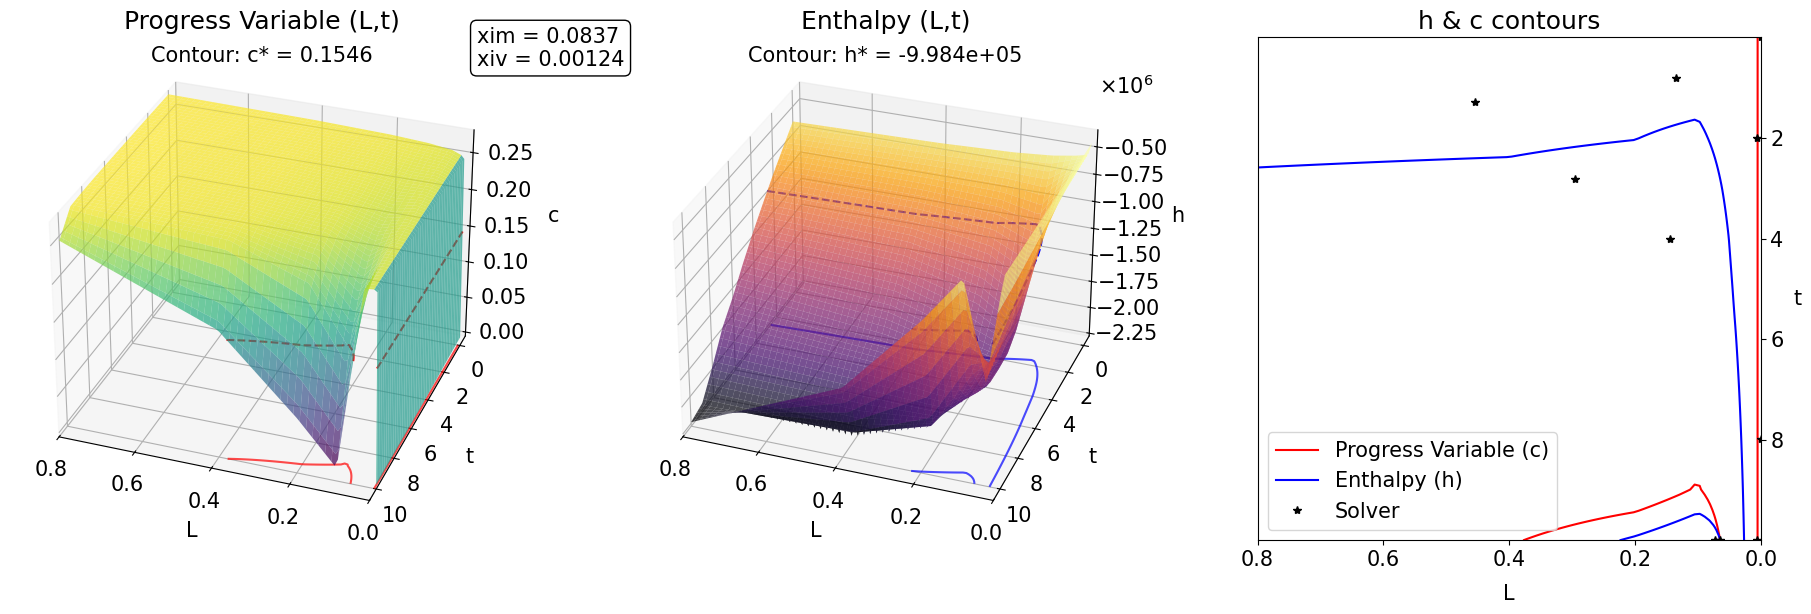

In [154]:
if input("Create animation of incorrect solve?")=='y':
    # Load in solver data
    solverDataFolder = r'./solver_data/20250121/'
    solverFilename = r'Xim_0.0837402716_Xiv_0.0012405055198286942_h_-9.984e+05_c_0.1546.txt'
    solverDataPath = solverDataFolder+solverFilename
    solverData = np.loadtxt(solverDataPath, dtype = float)

    # Parse solver data
    LSolver   = solverData[:,2]
    tSolver   = solverData[:,3]
    errSolver = solverData[:,4]

    # Parse data from file name
    pattern = r'(?:_)?(\w+)_([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)'
    matches = re.findall(pattern, solverFilename)
    solverInfo = {label: float(value) for label, value in matches}
    ximSolver = solverInfo['Xim']
    xivSolver = solverInfo['Xiv']
    hSolver   = solverInfo['h']
    cSolver   = solverInfo['c']
    print("Check vals: ", ximSolver, xivSolver, hSolver, cSolver)

    # Create data and plot
    scatterData = [np.array([LSolver[i], tSolver[i],]) for i in range(len(LSolver))]
    Ls, ts, hs, cs, xim, xiv = createPlotData(ximSolver, xivSolver, hInterp, cInterp, Lbounds, tbounds)

    fig = plt.figure(figsize = (20,20))
    # Function to animate the plot
    def animate(frame):
        previousPointsToShow = 10
        low = frame+1-previousPointsToShow
        if low < 0:
            low = 0
        plotHCLT(hSolver, cSolver, Ls, ts, hs, cs, xim, xiv, Lbounds, tbounds, scatterData[low:frame+1], save = False, fig = fig, LtickSpacing = 0.2)

    # Create the animation
    plt.ioff()
    ani = animation.FuncAnimation(fig, animate, frames=len(LSolver)-1, interval = 200)

    # Save the animation as a GIF
    ani.save(f'solverAnimation_failure.gif', writer='pillow', fps=5)
    plt.ion()

### T mismatch

Check vals:  0.75 0.046875 -596200.0 0.09023


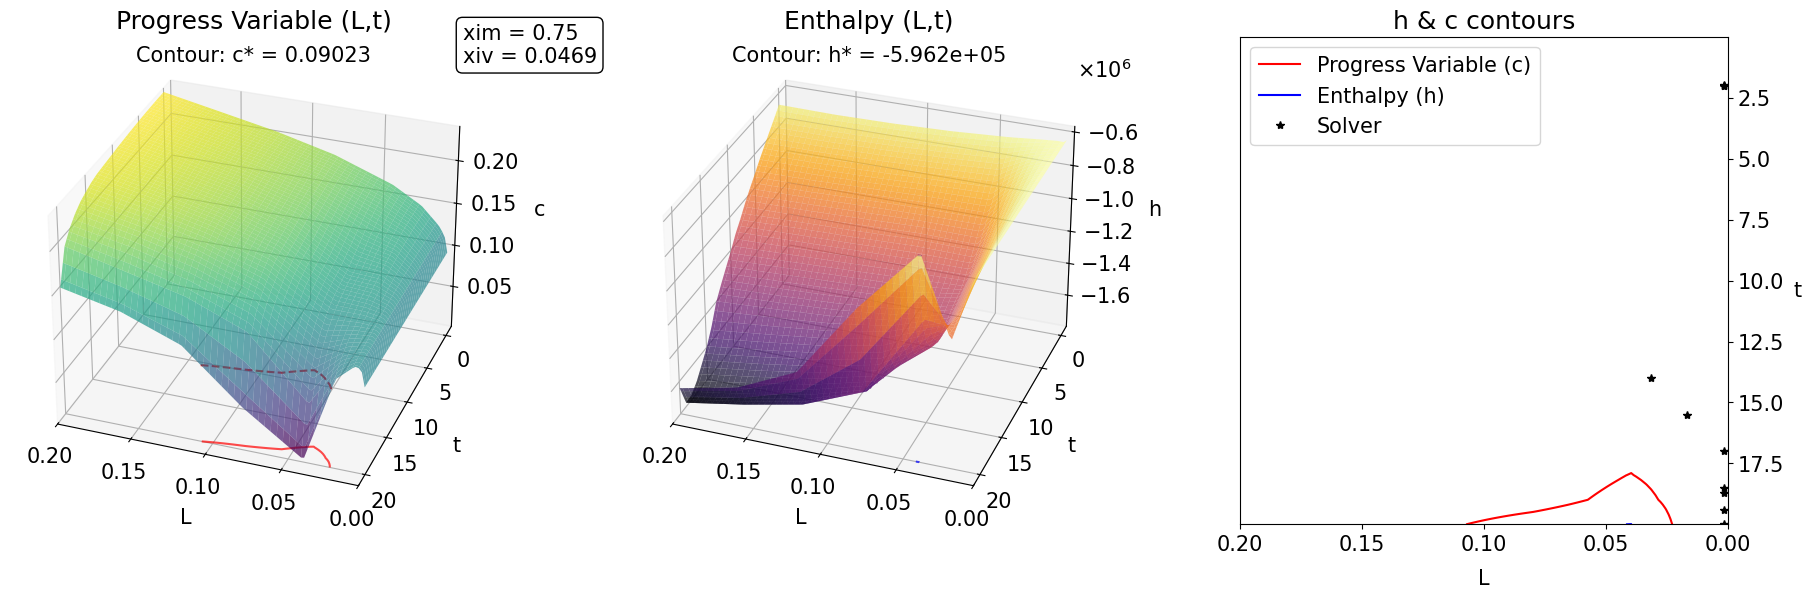

In [69]:
# Load in solver data
solverDataFolder = r'./solver_data/20241017/Tmismatch/'
solverFilename = r'Xim_0.75_Xiv_0.046875_h_-5.962e+05_c_0.09023.txt'
solverDataPath = solverDataFolder+solverFilename
solverData = np.loadtxt(solverDataPath, dtype = float)

# Parse solver data
LSolver   = solverData[:,2]
tSolver   = solverData[:,3]
errSolver = solverData[:,4]

# Parse data from file name
pattern = r'(?:_)?(\w+)_([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)'
matches = re.findall(pattern, solverFilename)
solverInfo = {label: float(value) for label, value in matches}
ximSolver = solverInfo['Xim']
xivSolver = solverInfo['Xiv']
hSolver   = solverInfo['h']
cSolver   = solverInfo['c']
print("Check vals: ", ximSolver, xivSolver, hSolver, cSolver)

# Create data and plot
scatterData = [np.array([LSolver[i], tSolver[i],]) for i in range(len(LSolver))]
Ls, ts, hs, cs, xim, xiv = createPlotData(ximSolver, xivSolver, hInterp, cInterp)

fig = plt.figure(figsize = (20,20))
# Function to animate the plot
def animate(frame):
    previousPointsToShow = 10
    low = frame+1-previousPointsToShow
    if low < 0:
        low = 0
    plotHCLT(hSolver, cSolver, Ls, ts, hs, cs, xim, xiv, scatterData[low:frame+1], save = False, fig = fig)

# Create the animation
plt.ioff()
ani = animation.FuncAnimation(fig, animate, frames=len(LSolver)-1, interval = 200)

# Save the animation as a GIF
ani.save(f'solverAnimation_Tmismatch.gif', writer='pillow', fps=5)
plt.ion()

### Correct solve

Check vals:  0.25 0.046875 -1000000.0 0.145


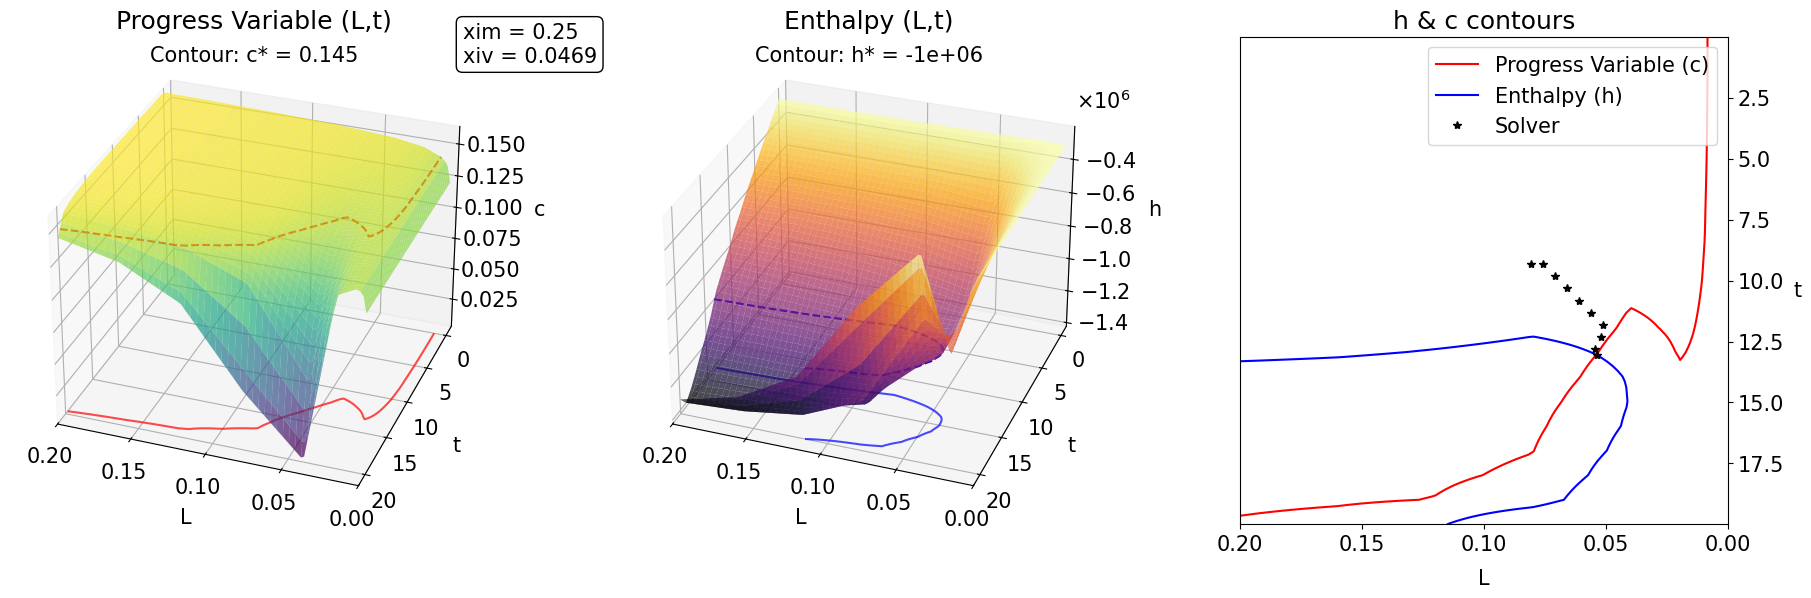

In [84]:
# Load in solver data
solverDataFolder = r'./solver_data/20241017/Success/'
solverFilename = r'Xim_0.25_Xiv_0.046875_h_-1e+06_c_0.145.txt'
solverDataPath = solverDataFolder+solverFilename
solverData = np.loadtxt(solverDataPath, dtype = float)

# Parse solver data
LSolver   = solverData[:,2]
tSolver   = solverData[:,3]
errSolver = solverData[:,4]

# Parse data from file name
pattern = r'(?:_)?(\w+)_([+-]?\d*\.?\d+(?:[eE][+-]?\d+)?)'
matches = re.findall(pattern, solverFilename)
solverInfo = {label: float(value) for label, value in matches}
ximSolver = solverInfo['Xim']
xivSolver = solverInfo['Xiv']
hSolver   = solverInfo['h']
cSolver   = solverInfo['c']
print("Check vals: ", ximSolver, xivSolver, hSolver, cSolver)

# Create data and plot
scatterData = [np.array([LSolver[i], tSolver[i],]) for i in range(len(LSolver))]
Ls, ts, hs, cs, xim, xiv = createPlotData(ximSolver, xivSolver, hInterp, cInterp)

fig = plt.figure(figsize = (20,20))
# Function to animate the plot
def animate(frame):
    previousPointsToShow = 10
    low = frame+1-previousPointsToShow
    if low < 0:
        low = 0
    plotHCLT(hSolver, cSolver, Ls, ts, hs, cs, xim, xiv, scatterData[low:frame+1], save = False, fig = fig)

# Create the animation
plt.ioff()
ani = animation.FuncAnimation(fig, animate, frames=len(LSolver)-1, interval = 200)

# Save the animation as a GIF
ani.save(f'solverAnimation_success.gif', writer='pillow', fps=5)
plt.ion()

### Animate h*, c*

In [1]:
# Create data
xim = 0.25
xiv = 0.25*xim*(1-xim)

# Create data and plot
scatterData = [[0.1, 6], [0.09, 4], [0.16, 8]]
scatterData = None
Ls, ts, hs, cs, xim, xiv = createPlotData(xim, xiv, hInterp, cInterp)
hknowns = np.linspace(np.max(hs), np.min(hs), 20)
cknowns = np.linspace(np.max(cs), np.min(cs), 20)


fig = plt.figure(figsize = (20,20))
# Function to animate the plot
def animate(frame):
    if frame < len(hknowns):
        hknown = hknowns[frame]
        cknown = cknowns[4]
    else:
        hknown = hknowns[10]
        cknown = cknowns[frame-len(hknowns)]
    plotHCLT(hknown, cknown, Ls, ts, hs, cs, xim, xiv, save = False, fig = fig)

# Create the animation
plt.ioff()
ani = animation.FuncAnimation(fig, animate, frames=19*2, interval = 200)

# Save the animation as a GIF
ani.save(f"hcAnimation.gif", writer='pillow', fps=5)
plt.ion()

NameError: name 'createPlotData' is not defined

# AICHE Regionals - A Priori Analysis

In [ ]:
#----- Import DOL-processed data
cols = "r, F, Frms, C, H, T, O2, N2, H2, H2O, CH4, CO, CO2, OH, NO" #from data file
ximcol = 1
xivcol = 2
hcol = 4
ccol = 3
tcol = 5

fileNames = [r"D075.Yall_proc", r"D30.Yall_proc", r"D60.Yall_proc", \
             r"D15.Yall_proc", r"D45.Yall_proc", r"D75.Yall_proc"]
filePath = r"./aPriori/processed/pmD.scat/"

# Storage arrays
t_table_data_all = np.empty(len(fileNames), dtype=np.ndarray)
data = np.empty((len(fileNames)), dtype=np.ndarray)

for j in range(len(fileNames)):                # For each file,
    netPath = filePath+fileNames[j]            # Get the path to the file,
    data[j] = np.loadtxt(netPath)[1:-1].T      # Load the file
    # NOTE: Indexing piece in the middle avoids xim=0
    t_data_table = np.ones(len(data[j][0]))*-1 # Initialize to store table-computed data
    
    for i in range(len(data[j][0])):
        xim = data[j][ximcol][i]
        xiv = data[j][xivcol][i]
        h   = data[j][hcol][i]
        c   = data[j][ccol][i]
        t_data_table[i] = T_table(xim, xiv, h, c)
    t_table_data_all[j] = t_data_table

print('done')

In [ ]:
colors = ['#FF0000', '#FFA500', '#00FF00', '#0000FF', '#4B0082', '#000000']

omit = 0 #number of plots to show simultaneously
for i in range(len(data)-omit):
    t_data_experiment = data[i][tcol]
    r = data[i][0]
    plt.plot(r, t_data_experiment, 'o', \
             color = colors[i])
    plt.plot(r, t_table_data_all[i], label = f"{fileNames[i]}", \
             color = colors[i])
plt.title("Table vs. Experiment")
plt.ylabel("Temperature (K)")
plt.xlabel(r"Radial Position")
plt.xlim((0,75))
plt.ylim((0,2000))
plt.legend();
print("""Dots = Experimental
Lines = Table""")

# Plotting T with Fixed $\xi_m$, $\xi_v$
Old code for conceptual review

## Plotting

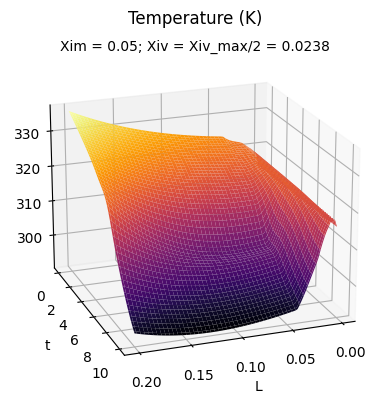

In [100]:
# Generate data
ximT = 0.05
xivT = ximT*(1-ximT)/2 #1/2 of max variance
num_points = 100
Ls = np.linspace(min(Lvals)+1e-4, max(Lvals)-1e-4, num_points)
ts = np.linspace(min(tvals)+1e-4, max(tvals)-1e-4, num_points)

xT, yT = np.meshgrid(Ls, ts)
Ts = np.zeros_like(x)

for i in range(num_points):
    for j in range(num_points):
        Ts[i, j] = It(xim, xiv, xT[i, j], yT[i, j])

# Plot data
zdata = Ts
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.view_init(elev=20, azim = 30)
ax.set_title("Temperature (K)")
ax.set_xlabel("L")
ax.set_ylabel("t")
ax.view_init(20, 70)
ax.set_zlim(bottom=np.min(zdata), top=np.max(zdata))
ax.plot_surface(xT, yT, zdata, cmap='inferno')
ax.text2D(0.5, 0.95, rf'Xim = {ximT:.2f}; Xiv = Xiv_max/2 = {xivT:.4f}', transform=ax.transAxes, ha='center')

plt.savefig(f'./figures/3DTemperature_xim_{ximT:.2f}_xiv_{xivT:.4f}.png',bbox_inches='tight')  # Save as a PNG file

## Animating

In [96]:
#Create Data
ximTarr = np.linspace(0.01, 0.99, 10)
xivTarr = ximTarr*(1-ximTarr)/2 #1/2 of max variance
num_points = 30
Ls = np.linspace(min(Lvals)+1e-4, max(Lvals)-1e-4, num_points)
ts = np.linspace(min(tvals)+1e-4, max(tvals)-1e-4, num_points)

xT, yT = np.meshgrid(Ls, ts)
Ts = np.zeros((len(ximTarr), len(Ls), len(ts)))

for k in range(len(ximTarr)):
    xim = ximTarr[k]
    xiv = xivTarr[k]
    print(k)
    for i in range(num_points):
        for j in range(num_points):
            Ts[k,i,j] = It(xim, xiv, xT[i, j], yT[i, j])

0
1
2
3
4
5
6
7
8
9


Current frame:  0
Current frame:  0
Current frame:  1
Current frame:  2
Current frame:  3
Current frame:  4
Current frame:  5
Current frame:  6
Current frame:  7
Current frame:  8
Current frame:  9
Current frame:  10
Current frame:  11
Current frame:  12
Current frame:  13
Current frame:  14
Current frame:  15
Current frame:  16
Current frame:  17
Current frame:  18
Current frame:  19
Current frame:  0


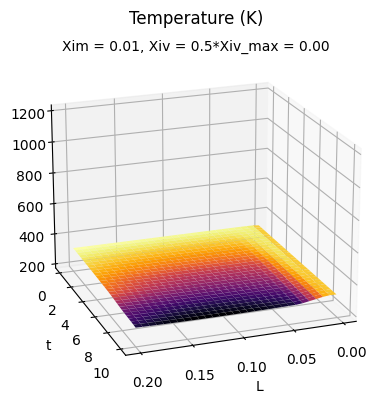

In [97]:
#Animate
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

animData = Ts
# Function to animate the plot
def animate(frame):
    print("Current frame: ", frame)
    if frame >= len(animData):
        frame = 2*len(animData)-1-frame
    ax.clear()  # Clear previous plot to update with new data
    ax.set_title("Temperature (K)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.view_init(20, 70)
    ax.set_zlim(bottom=np.min(animData), top=np.max(animData))
    surf = ax.plot_surface(xT, yT, animData[frame], cmap='inferno')
    ax.text2D(0.5, 0.95, f'Xim = {ximTarr[frame]:.2f}, Xiv = 0.5*Xiv_max = {xivTarr[frame]:.2f}', transform=ax.transAxes, ha='center')
    return surf,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=2*len(animData), interval=200)

# Save the animation as a GIF
ani.save(f'Temperature_VariableXimXiv.gif', writer='pillow', fps=5)

## Interactive Plots

In [10]:
#----- Interactive plots
def interact1(theta, phi, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x,y,z1, cmap='inferno')
    contour_lines = ax.contour(x, y, z1, zdir='z', levels=[z], colors='r')
    contour_bottom = ax.contour(x, y, z1, zdir='z', levels=[z], colors='r', offset = 0)
    ax.set_title("Enthalpy(L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("h")
    ax.view_init(theta, phi)
    plt.show();

def interact2(theta, phi, z):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(x,y,z2, cmap='viridis')
    contour_lines = ax.contour(x, y, z2, zdir='z', levels=[z], colors='r')
    contour_bottom = ax.contour(x, y, z2, zdir='z', levels=[z], colors='r', offset = 0)
    ax.set_title("Progress Variable (L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("c")
    
    ax.view_init(theta, phi)
    plt.show();


#wgt.interact(interact1, theta=(0,90), phi=(0,360), z)
wgt.interact(interact2, theta=(0,90), phi=(0,360), z = np.arange(0.01, 0.13, 0.01))

interactive(children=(IntSlider(value=45, description='theta', max=90), IntSlider(value=180, description='phi'…

<function __main__.interact2(theta, phi, z)>

# Archive

## Old tm2 table generation code

In [ ]:
numXim = 80
ximLfrac = 0.2
ximGfrac = 0.4
numXiv = 20
path = r"./data/lignellDec1"
tvals = np.arange(0,11,1)
Lvals = [0.004, 0.005, 0.006, 0.01, 0.04, 0.1, 0.2, 0.4, 0.8]
Lbounds = [min(Lvals), max(Lvals)]
tbounds = [min(tvals), max(tvals)]

if input("Run table generation?") == 'y':
    # Make sure Lvals is strictly increasing
    for i in range(len(Lvals)-1):
        if Lvals[i+1] > Lvals[i]:
            pass
        else:
            print(f"NO: {Lvals[i+1]} < {Lvals[i]}")

    #----- Need to generate the tables twice: the first method allows us to get h and c interpolators to create plots later on
    data_output = tm2.get_data_files(path, Lvals, tvals)
    def create_table(args):
        return tm2.makeLookupTable(*args)

    # Prepare arguments for each call
    file_pattern = r'^L.*.dat$'
    c_components = ['H2', 'H2O', 'CO', 'CO2']
    interpKind = 'cubic'
    table_args = [
        (path, Lvals, tvals, file_pattern, c_components, 'T', interpKind, numXim, numXiv, data_output, ximLfrac, ximGfrac),
        (path, Lvals, tvals, file_pattern, c_components, 'h', interpKind, numXim, numXiv, data_output, ximLfrac, ximGfrac),
        (path, Lvals, tvals, file_pattern, c_components, 'c', interpKind, numXim, numXiv, data_output, ximLfrac, ximGfrac),
    ]

    start = time.time()
    # Use ProcessPoolExecutor to run table creation in parallel
    with ProcessPoolExecutor(mp_context=mp.get_context('fork')) as executor:
        futures = {executor.submit(create_table, args): idx for idx, args in enumerate(table_args)}

        results = {}
        for future in concurrent.futures.as_completed(futures):
            idx = futures[future]
            try:
                results[idx] = future.result()
            except Exception as e:
                print(f"Table creation for index {idx} generated an exception: {e}")

    # Unpack results into separate variables
    T_table, T_indices = results[0]
    h_table, h_indices = results[1]
    c_table, c_indices = results[2]

    end = time.time()
    print("Time elapsed creating auxiliary tables:", end - start)

    # Create table
    start = time.time()

    #----- Get function to get T(xim, xiv, h, c)
    T_func = tm2.phiTable(path, Lvals, tvals, phi = 'T', 
                        numXim = numXim, numXiv = numXiv, parallel = True,
                        ximLfrac = ximLfrac, ximGfrac = ximGfrac)

    end = time.time()
    print("Time elapsed creating T_func:", end - start)

## tm2 Testing

Code in this block was used to confirm allignment between version of the tableMaker code.

### Generate tables

#### Old Code - Serial

In [ ]:
# OLD CODE: tableMaker
# NOTE: "OS" = 'old, Serial'

start = time.time()

numXim = 5
numXiv = 5
path = r"./aPriori/TNF"
Lvals = [0.00135, 0.0014, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
tvals = np.arange(0,11,1)

data_output_old = tableMaker.get_data_files(path, Lvals, tvals)

#----- Create T Table
table_OS, indices_OS = tableMaker.makeLookupTable(path, Lvals, tvals, phi='T',
                                    numXim = numXim, numXiv = numXiv, 
                                    get_data_files_output = data_output_old)
h_table_OS, h_indices_OS = tableMaker.makeLookupTable(path, Lvals, tvals, phi='h',
                                    numXim = numXim, numXiv = numXiv, 
                                    get_data_files_output = data_output_old)
c_table_OS, c_indices_OS = tableMaker.makeLookupTable(path, Lvals, tvals, phi='c',
                                    numXim = numXim, numXiv = numXiv, 
                                    get_data_files_output = data_output_old)

end = time.time()
print(end-start)

# Testing the new code 
It_OS = tableMaker.createInterpolator(table_OS, indices_OS)
Ih_OS = tableMaker.createInterpolator(h_table_OS, h_indices_OS)
Ic_OS = tableMaker.createInterpolator(c_table_OS, c_indices_OS)

#----- Define function to get T(xim, xiv, h, c) from table (OLD METHOD)
Lbounds = [min(Lvals), max(Lvals)]
tbounds = [min(tvals), max(tvals)]
    
def T_table_OS(xim, xiv, h, c):
    L,t = tableMaker.Lt_hc(h, c, xim, xiv, Ih_OS, Ic_OS, Lbounds, tbounds)
    return It_OS(xim, xiv, L, t)

/Users/cougar/jaredporter/inferno/codes/TableMakerMain/postGit/LiuInt.py:86: IntegrationWarning: The maximum number of subdivisions (50) has been achieved.
  If increasing the limit yields no improvement it is advised to analyze 
  the integrand in order to determine the difficulties.  If the position of a 
  local difficulty can be determined (singularity, discontinuity) one will 
  probably gain from splitting up the interval and calling the integrator 
  on the subranges.  Perhaps a special-purpose integrator should be used.
  p2 = quad(ϕP, ϵ, 1-ϵ, args = (a, b))[0]   # ϵ   < ξ < 1-ϵ


KeyboardInterrupt: 

#### Old Code - Parallel

In [ ]:
# OLD CODE: tableMaker
start = time.time()

def create_table(args):
    path, Lvals, tvals, phi, numXim, numXiv, data_output_old = args
    return tableMaker.makeLookupTable(path, Lvals, tvals, phi=phi,
                                    numXim = numXim, numXiv = numXiv, 
                                    get_data_files_output = data_output_old)

path = r"./aPriori/TNF"
Lvals = [0.00135, 0.0014, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
tvals = np.arange(0,11,1)
numXim = 5
numXiv = 5
data_output_old = tableMaker.get_data_files(path, Lvals, tvals)

# Prepare arguments for each call
table_args = [
    (path, Lvals, tvals, 'T', numXim, numXiv, data_output_old),
    (path, Lvals, tvals, 'h', numXim, numXiv, data_output_old),
    (path, Lvals, tvals, 'c', numXim, numXiv, data_output_old),
]

# Use ProcessPoolExecutor to run table creation in parallel
with ProcessPoolExecutor() as executor:
    futures = {executor.submit(create_table, args): idx for idx, args in enumerate(table_args)}

    results = {}
    for future in concurrent.futures.as_completed(futures):
        idx = futures[future]
        try:
            results[idx] = future.result()
        except Exception as e:
            print(f"Table creation for index {idx} generated an exception: {e}")

# Unpack results into separate variables
table_OP, indices_OP = results[0]
h_table_OP, h_indices_OP = results[1]
c_table_OP, c_indices_OP = results[2]

end = time.time()
print(end-start)

# Testing the new code 
It_OP = tableMaker.createInterpolator(table_OP, indices_OP)
Ih_OP = tableMaker.createInterpolator(h_table_OP, h_indices_OP)
Ic_OP = tableMaker.createInterpolator(c_table_OP, c_indices_OP)

#----- Define function to get T(xim, xiv, h, c) from table (OLD METHOD)
Lbounds = [min(Lvals), max(Lvals)]
tbounds = [min(tvals), max(tvals)]
    
def T_table_OP(xim, xiv, h, c):
    L,t = tableMaker.Lt_hc(h, c, xim, xiv, Ih_OP, Ic_OP, Lbounds, tbounds)
    return It_OP(xim, xiv, L, t)

83.65903663635254


#### New Code - Serial

In [ ]:
# NEW CODE: tm2
start = time.time()

path = r"./aPriori/TNF"
Lvals = [0.00135, 0.0014, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
tvals = np.arange(0,11,1)

#----- Get function to get T(xim, xiv, h, c) (NEW METHOD)
T_table_NS = tm2.phiTable(path, Lvals, tvals, phi = 'T', 
                        numXim = numXim, numXiv = numXiv, parallel = False)

end = time.time()
print(end - start)

199.90124535560608


#### New Code - Parallel

In [ ]:
# NEW CODE: tm2
start = time.time()

path = r"./aPriori/TNF"
Lvals = [0.00135, 0.0014, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
tvals = np.arange(0,11,1)

#----- Get function to get T(xim, xiv, h, c) (NEW METHOD)
T_table_NP = tm2.phiTable(path, Lvals, tvals, phi = 'T', 
                        numXim = numXim, numXiv = numXiv, parallel = True)

end = time.time()
print(end - start)

80.75290322303772


In [ ]:
# Testing - trying to handle error with singular Jacobian
T_table_NP[0](0, 0, -7178.7 , 0)

array([291.])

### Compare new vs. old $T(\bar{\xi})$

In [ ]:
# For a number of points, 
# Determine the "real" value by grabbing it from a table
# Pass the table parameters into each interpolator
# Compare accuracy
from random import randint

numCompares = 10
ximLen = len(h_indices_OS[0])
xivLen = len(h_indices_OS[1][0])
LLen   = len(h_indices_OS[2])
tLen   = len(h_indices_OS[3])

for i in range(numCompares):
    ximInd = randint(0, ximLen-1)
    xivInd = randint(0, xivLen-1) # zero variance case led to some issue...
    LInd = randint(0, LLen-1)
    tInd = randint(0, tLen-1)
    ximreal = h_indices_OS[0][ximInd]
    xivreal = h_indices_OS[1][ximInd][xivInd]
    Lreal = h_indices_OS[2][LInd]
    treal = h_indices_OS[3][tInd]
    hreal = h_table_OS[ximInd][xivInd][LInd][tInd]
    creal = c_table_OS[ximInd][xivInd][LInd][tInd]
    Treal = table_OS[ximInd][xivInd][LInd][tInd]

    print(f"Conditions: xim = {ximreal}, xiv = {xivreal}, hreal = {hreal:.5g}, creal = {creal:.5g}")
    print(f"             L = {Lreal}, t = {treal}, T = {Treal}")
    OS = T_table_OS(ximreal, xivreal, hreal, creal)
    OP = T_table_OP(ximreal, xivreal, hreal, creal)
    NS = T_table_NS[0](ximreal, xivreal, hreal, creal)
    NP = T_table_NP[0](ximreal, xivreal, hreal, creal)
    print(f"OS: {OS:.5g}")
    print(f"OP: {OP:.5g}")
    print(f"NS: {NS[0]:.10g}")
    print(f"NP: {NP[0]:.10g}")
    print()


KeyboardInterrupt



## (L, t) -> (h,c) algorithm (tableMaker code)

### Create tables

In [ ]:
#Table Test: time the creation of a temperature table 
from Archive import tableMaker as tableMaker   
import time

path = r"./aPriori/TNF"
Lvals = [0.00135, 0.0014, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2]
tvals = np.arange(0,11,1)

data_output = tm2.get_data_files(path, Lvals, tvals)

#----- Create T Table
start = time.process_time()
table, indices = tableMaker.makeLookupTable(path, Lvals, tvals, phi='T', 
                                           get_data_files_output = data_output)
elapsed = (time.process_time()-start)
print(f"Time elapsed to process temperature table = {elapsed:.2f} seconds")

#----- Create h & c tables
h_table, h_indices = tableMaker.makeLookupTable(path, Lvals, tvals, phi='h', 
                                           get_data_files_output = data_output)
c_table, c_indices = tableMaker.makeLookupTable(path, Lvals, tvals, phi='c', 
                                           get_data_files_output = data_output)
print('h & c tables complete')

Time elapsed to process temperature table = 27.43 seconds
h & c tables complete


### Interpolator testing

In [ ]:
# Test the Interpolator
Ih = tableMaker.createInterpolator(h_table, h_indices)
Ic = tableMaker.createInterpolator(c_table, c_indices)
It = tableMaker.createInterpolator(table, indices)

print(h_indices)
#---------------
print("h test:")
xim = 0.25
xiv = 0.25*xim*(1-xim)
L = 0.002
t = 5
htest = h_table[1][1][3][5]
print(htest) 
print(Ih(xim, xiv, L, t))
print()

print("c test:")
ctest = c_table[1][1][3][5]
print(ctest)
print(Ic(xim, xiv, L, t))
print()

print("T test:")
ttest = table[1][1][3][5]
print(ttest)
print(It(xim, xiv, L, t))
print()

print("If values above are equivalent, the interpolator is working as expected.")

[array([0.  , 0.25, 0.5 , 0.75, 1.  ]), array([[0.      , 0.      , 0.      , 0.      , 0.      ],
       [0.      , 0.046875, 0.09375 , 0.140625, 0.1875  ],
       [0.      , 0.0625  , 0.125   , 0.1875  , 0.25    ],
       [0.      , 0.046875, 0.09375 , 0.140625, 0.1875  ],
       [0.      , 0.      , 0.      , 0.      , 0.      ]]), [0.00135, 0.0014, 0.0016, 0.002, 0.004, 0.006, 0.008, 0.02, 0.04, 0.2], array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10])]
h test:
-286731.75702770625
-286731.7606373748

c test:
0.13368329603843968
0.13368329976183368

T test:
1148.8296645257617
1148.829689572824

If values above are equivalent, the interpolator is working as expected.


### (h,c) $\rightarrow$ (L,t) test

In [ ]:
importlib.reload(tm2)
Lbounds = [min(Lvals), max(Lvals)]
tbounds = [min(tvals), max(tvals)]
hval = htest
cval = ctest+0.001
norm = np.max(h_table)/np.max(c_table)

ans = tm2.Lt_hc_newton(hval, cval, xim, xiv, Ih, Ic, Lbounds, tbounds, norm = norm)

print()
print(f"Goal L = {L:.6f} | Solved L = {ans[0]:.6f}")
print(f"Goal t = {t:.6f} | Solved t = {ans[1]:.6f}")
print()

print("If the values above match, the algorithm found a table value.")
print("If the values above don't match exactly but no error was thrown, then the solver might have found another solution.")


Goal L = 0.002000 | Solved L = 0.002276
Goal t = 5.000000 | Solved t = 2.524780

If the values above match, the algorithm found a table value.
If the values above don't match exactly but no error was thrown, then the solver might have found another solution.


## extractContour Function

In [ ]:
def extractContour(zval, data):
    """
    Extracts the contour line data for Z = z(x,y). 
    Inputs: 
        zval: contour's value of z
        data: tuple or array with 3 elements (in order):
            X: meshed array of x data points (2D
            Y: meshed array of y data points (2D)
                NOTE: xdata, ydata = np.meshgrid(xdata ydata)
            Z: array of z data points (2D)
    Outputs: 
        lines: numpy array of points [x,y,z] 
    Example usage: 
        >>> zval   = 0.10
        >>> X, Y   = np.meshgrid(xdata, ydata)
        >>> data   = (X, Y, zdata)
        >>> points = extractContour(zval, data)
        >>> fig    = plt.figure()
        >>> ax     = fig.add_subplot(111, projection='3d')
        >>> ax.scatter(points[:,0], points[:,1], points[:,2])
    """
    xdat, ydat, zdat = data
    X, Y = np.meshgrid(xdat, ydat)
    contour_lines = plt.contour(xdat, ydat, zdat, levels = (zval,))

    # Find intersection points of contour lines with the plane
    lines = []
    for line_collection in contour_lines.collections:
        for path in line_collection.get_paths():
            vertices = path.vertices
            for point in vertices:
                xpt, ypt = point
                lines.append([xpt, ypt, zval])

    plt.close()
    return np.array(lines)

## Making a Jacobian calculator
This code is now implemented in tm2. This was coded outside of the main code so that I could benchmark it against sympy's existing jacobian calculator. Result: manually-coded solution is ~10x faster

In [ ]:
def getJac(F, X):
    """Computes the 2x2 Jacobian of F(X) at X
    NOTE: This function assumes constant xim and xiv. These parameters are included in F and X
            to allow a generic function to be used.
    Params:
        F: f(mvlt) = [h(mvlt), c(mvlt)]
            def F(mvlt):
                return np.array([hInterp(*mvlt), cInterp(*mvlt)])
        X: [xim, xiv L, t]
    Returns:
        J: [[dH/dL  dH/dt],
            [dc/dL  dc/dt]]
    """
    # Confirm X is an array
    X = np.array(X)

    # Get initial point
    F0 = F(X)

    # Set deltas
    eps = 1e-16 # machine precision
    scalar = np.sqrt(eps)
    deltaL = np.array([0, 0, X[2]*scalar, 0])
    deltat = np.array([0, 0, 0, X[3]*scalar])
    
    # Compute gradients
    J0 = (F(X + deltaL)-F0)/deltaL[2]  # = [dH/dL, dc/dL]
    J1 = (F(X + deltat)-F0)/deltat[3]  # = [dH/dt, dc/dt]

    return np.array([J0, J1]).T

def hInterp(xim, xiv, L, t):
    return xim**2+ xiv**(-2) + L**3 + 2*t

def cInterp(xim, xiv, L, t):
    return xim**(-3) + xiv + L**2 - 0.4*t

def F(mvlt):
    return np.array([hInterp(*mvlt), cInterp(*mvlt)])

# Manually-coded solution
X = [100, 0.2, 0.05, 0.2]

import timeit
times = []
for i in range(1000):
    start = timeit.timeit()
    getJac(F, X)
    end = timeit.timeit()
    times.append(end - start)
print(getJac(F, X))
print(f"Average time = {np.mean(times):.2e} s")

[[ 0.00727596  1.99997885]
 [ 0.10000001 -0.4       ]]
Average time = -1.77e-04 s


Result: manual-coded is faster by ~ 10x

In [ ]:
arr1 = np.array([0, 0, 2 ,3 ])
arr2 = np.array([0.1, 0.1, 0.1, 0.1])
(arr1<arr2).all()

False

## Compare tableMaker and tm2
When this was made, the only major difference was that tm2 interpolated using normalized values of $\sigma^2$, whereas tableMaker interpolated in the variance coordinate directly.

In [40]:
import codes.TableMakerMain.postGit.Archive.tableMaker as tableMaker
import tableMakerv2 as tM2
#----- Create T Table
phi = 'T'
table, indices = tableMaker.makeLookupTable(path, Lvals, tvals, phi,
                                    numXim = 5, numXiv = 5, get_data_files_output = data_output)
table2, indices2 = tM2.makeLookupTable(path, Lvals, tvals, phi, 
                                       numXim =5, numXiv = 5, get_data_files_output = data_output)

# Testing the new code 
It1 = tableMaker.createInterpolator(table, indices)
It2 = tM2.createInterpolator(table2, indices2)

# This is a point on the grid.
xim = 0.5
xiv = 0.125
L = 0.02
t = 2
# When using a grid point, the values line up almost exactly.
print(It1(xim, xiv, L, t))
print(It2(xim, xiv, L, t))

# This isn't a point on the grid:
xim = 0.4
xiv = xim*(1-xim)*0.3
L = 0.02
t = 2
# When using a non-grid point, the two can differ greatly.
print(It1(xim, xiv, L, t))
print(It2(xim, xiv, L, t))

1043.3231273496444
1043.3231260830655
1306.4790377923755
1337.6920124389962


## Contour Plot Demo
Demonstration of matplotlib's default ability to find specific contours (used in creating visual representations of the (h,c) -> (L,t) solve)

## Animate over values of $\xi_{mean}$
 WARNING: data  population may be incorrect. See method used above. 

In [ ]:
#Create data
xim = np.linspace(0.01,0.99,20)
xiv = xim*(1-xim)/2 #Set xiv to be 1/2 of the maximum value for a given xim.
Ls = np.linspace(min(Lvals)+1e-3, max(Lvals)-1e-3, 50)
ts = np.linspace(min(tvals)+1e-3, max(tvals)-1e-3, 50)
hs = np.ones((len(xim), len(Ls), len(ts)))
cs = np.ones((len(xim), len(Ls), len(ts)))
for i in range(len(xim)):
    print(i)
    for l in range(len(Ls)):
        for t in range(len(ts)):
            hs[i,l,t] = Ih(xim[i], xiv[i], Ls[l], ts[t])
            cs[i,l,t] = Ic(xim[i], xiv[i], Ls[l], ts[t])

print("Checkpoint1")
x, y = np.meshgrid(Ls, ts)
z1 = hs
z2 = cs

0
1
2
3
4


/home/jaredwp91/.local/lib/python3.8/site-packages/scipy/optimize/_minpack_py.py:178: RuntimeWarning: The iteration is not making good progress, as measured by the 
  improvement from the last ten iterations.
  warnings.warn(msg, RuntimeWarning)


5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
Checkpoint1


### h = h(t)

NameError: name 'animation' is not defined

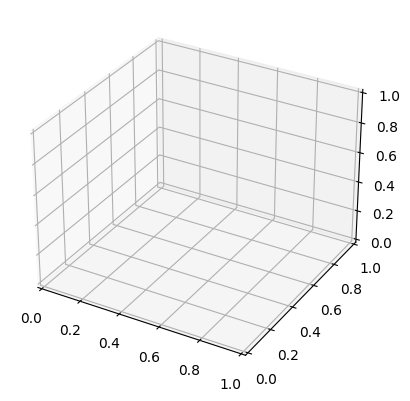

In [ ]:
import matplotlib.animation as animation

# Animate the plot for enthalpy
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Function to animate the plot
def animate(frame):
    print("Current frame: ", frame)
    if frame >= len(z1):
        frame = 2*len(z1)-1-frame
    ax.clear()  # Clear previous plot to update with new data
    ax.view_init(elev=20, azim = 30)
    ax.set_title("Enthalpy(L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("h")
    ax.set_zlim(bottom=np.min(z1), top=np.max(z1))
    surf = ax.plot_surface(x, y, z1[frame], cmap='inferno')
    ax.text2D(0.5, 0.95, f'Xim = {xim[frame]:.2f}, Xiv = 0.5*Xiv_max = {xiv[frame]:.2f}', transform=ax.transAxes, ha='center')
    return surf,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=2*len(z1), interval=200)

# Save the animation as a GIF
ani.save(f'Enthalpy_VariableXimXiv.gif', writer='pillow', fps=5)

### c = c(t)

Current frame:  0
Current frame:  0
Current frame:  1
Current frame:  2
Current frame:  3
Current frame:  4
Current frame:  5
Current frame:  6
Current frame:  7
Current frame:  8
Current frame:  9
Current frame:  10
Current frame:  11
Current frame:  12
Current frame:  13
Current frame:  14
Current frame:  15
Current frame:  16
Current frame:  17
Current frame:  18
Current frame:  19
Current frame:  20
Current frame:  21
Current frame:  22
Current frame:  23
Current frame:  24
Current frame:  25
Current frame:  26
Current frame:  27
Current frame:  28
Current frame:  29
Current frame:  30
Current frame:  31
Current frame:  32
Current frame:  33
Current frame:  34
Current frame:  35
Current frame:  36
Current frame:  37
Current frame:  38
Current frame:  39
Current frame:  0


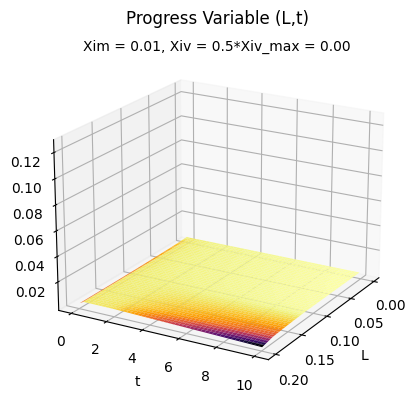

In [ ]:
# Animate the plot for progress variable
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Function to animate the plot
def animate(frame):
    print("Current frame: ", frame)
    if frame >= len(z2):
        frame = 2*len(z2)-1-frame
    ax.clear()  # Clear previous plot to update with new data
    ax.view_init(elev=20, azim = 30)
    ax.set_title("Progress Variable (L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("c")
    ax.set_zlim(bottom=np.min(z2), top=np.max(z2))
    surf = ax.plot_surface(x, y, z2[frame], cmap='inferno')
    ax.text2D(0.5, 0.95, f'Xim = {xim[frame]:.2f}, Xiv = 0.5*Xiv_max = {xiv[frame]:.2f}', transform=ax.transAxes, ha='center')
    return surf,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=2*len(z2), interval=200)

# Save the animation as a GIF
ani.save(f'ProgressVariable_VariableXimXiv.gif', writer='pillow', fps=5)

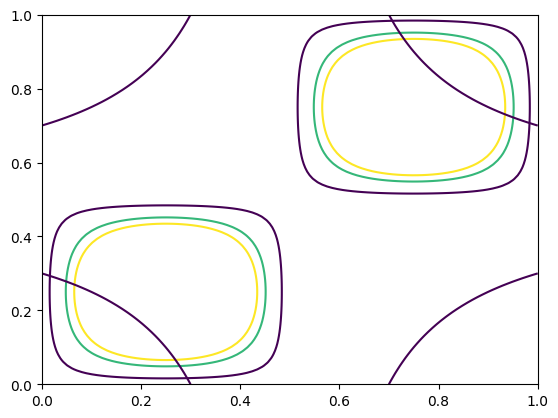

In [185]:
x = np.linspace(0,1,100)
y = np.linspace(0,1,100)
X,Y = np.meshgrid(x,y)

Z = np.sin(2*np.pi*X)*np.sin(2*np.pi*Y)
W = (X-0.5)**2 * (Y-0.5)**2

plt.contour(X,Y,Z, levels = [0.1,0.3,0.4])
plt.contour(X,Y,W, levels = [0.01]);

## Rotating Plot Animation
Note: some kind of x, y, and z data is needed for this code to work.

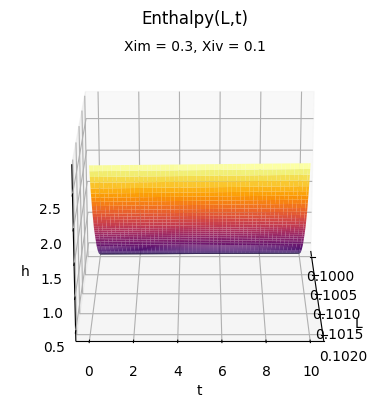

In [12]:
from matplotlib import animation

#----- Animate the plot
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Function to animate the plot
def animate(frame):
    ax.clear()  # Clear previous plot to update with new data
    ax.view_init(elev=20, azim=4*frame)
    ax.set_title("Enthalpy(L,t)")
    ax.set_xlabel("L")
    ax.set_ylabel("t")
    ax.set_zlabel("h")
    surf = ax.plot_surface(x, y, z1, cmap='inferno')
    ax.text2D(0.5, 0.95, f'Xim = {xim}, Xiv = {xiv}', transform=ax.transAxes, ha='center')
    return surf,

# Create the animation
ani = animation.FuncAnimation(fig, animate, frames=90, interval=200)

# Save the animation as a GIF
ani.save(f'Enthalpy_xim{xim}_xiv{xiv}.gif', writer='pillow', fps=15)

## Regex Testing

In [ ]:
#Testing Grounds

#Array masking
a = np.ones(10)*(-1)
for i in range(len(a)-1):
    a[i] = np.random.rand()
aNew = a[a!=-1]

#Regex
pattern = r"L_([\d.]+)[SU]_([\d.]+)\.dat"
candidates = ["L_0.03U_198.dat", "L_0.002S_299.dat", "L0990U900.dat"]
for c in candidates:
    print(search(pattern, c))

L = 0.03
pattern2 =  f"L_{L}[SU]_[\d]*\.dat"
arr2 = ["L_0.02S_001.dat", "L_0.02S_003.dat", "L_0.02S_002.dat", "L_0.02U_001.dat", "L_0.03S_001.dat"]
print("Here", len([name for name in arr2 if match(pattern2, name)]))
arr = [0.1, 0.4, 0.5, 0.2, 0.7, 0.15]
print(np.sort(arr)[::-1])

## $\beta$-PDF Endpoint Behavior Testing

In [ ]:
# Fidelity Test: trying to determine the behavior of the BetaPDF near 0 and 1
import LiuInt as LI
from tm2 import phiFuncs
function = phiFuncs("../flame/run", 'T', fileName = 'L_0.002U_24.dat')

#For what value of xim is xim = 0 = x a good approximation? 
#Hypothesis: Something beneath 1e-6 will work fine. 
Min = -1
xim = np.logspace(0, Min,10)
xiv = np.logspace(0, Min,10)
import matplotlib.pyplot as plt
from matplotlib import ticker, cm
  
# Creating 2-D grid of features 
[X, Y] = np.meshgrid(xim, xiv) 
  
fig, ax = plt.subplots(1, 1) 

Z = np.zeros((len(xim), len(xiv)))
for i in range(len(xim)):
    for j in range(len(xiv)):
        Z[i,j] = LI.IntegrateForPhiBar(xim[i], xiv[j], function)

# plots filled contour plot 
ax.contourf(X, Y, Z) 
  
ax.set_title('Predicted values') 
ax.set_xlabel('Xim') 
ax.set_xscale('log')
ax.set_ylabel('Xiv')
ax.set_yscale('log')
cs = ax.contourf(X, Y, Z, locator=ticker.LogLocator(), cmap=cm.PuBu_r)
cbar = fig.colorbar(cs)
  
plt.show() 
plt.savefig('Fidelity_min.png', dpi=300, bbox_inches='tight')